# Libraries

In [1]:
import numpy as np
import pandas as pd 
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import plotly.express as px
!pip install pmdarima --quiet --disable-pip-version-check
import pmdarima as pm
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, r2_score,max_error, mean_absolute_percentage_error , mean_absolute_error, explained_variance_score
from scipy.stats import ttest_ind, f_oneway
from prophet.plot import add_changepoints_to_plot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sns.set_style("whitegrid")
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MaxPooling1D, Flatten

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV

from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")


# Data Uploading

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

In [3]:
df = pd.read_csv(file_path)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [5]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [6]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Date', 'Open', 'High', 'Low', 'Close', 'Volume','Adj_Close'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df['Date'], df['Open'], df['High'], df['Low'], df['Close'], df['Volume'], df['Adj Close']],
               fill_color='lavender',
               align='left'))
])

fig.show()

# Exploratory Data Analysis

In [7]:
df.Date = pd.to_datetime(df.Date)

In [8]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df.describe()

Date         Open         High          Low  \
count                           5842  5842.000000  5842.000000  5842.000000   
mean   2008-12-22 20:41:34.488188928   372.707174   376.921392   368.114569   
min              1997-05-15 00:00:00     1.406250     1.447917     1.312500   
25%              2003-03-07 18:00:00    37.955001    38.547501    37.207500   
50%              2008-12-22 12:00:00    83.428749    84.945000    81.656250   
75%              2014-10-12 06:00:00   359.729988   363.439987   356.280006   
max              2020-07-31 00:00:00  3251.060059  3344.290039  3151.000000   
std                              NaN   585.571802   591.766458   578.660700   

             Close    Adj Close        Volume  
count  5842.000000  5842.000000  5.842000e+03  
mean    372.746660   372.746660  7.519048e+06  
min       1.395833     1.395833  4.872000e+05  
25%      37.927499    37.927499  3.684900e+06  
50%      83.459999    83.459999  5.657200e+06  
75%     360.047501   360.047501  8.533400e+06  
max    3200.000000  3200.000000  1.043292e+08  
std     585.607655   585.607655  7.282683e+06

In [11]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [12]:
df.shape

(5842, 8)

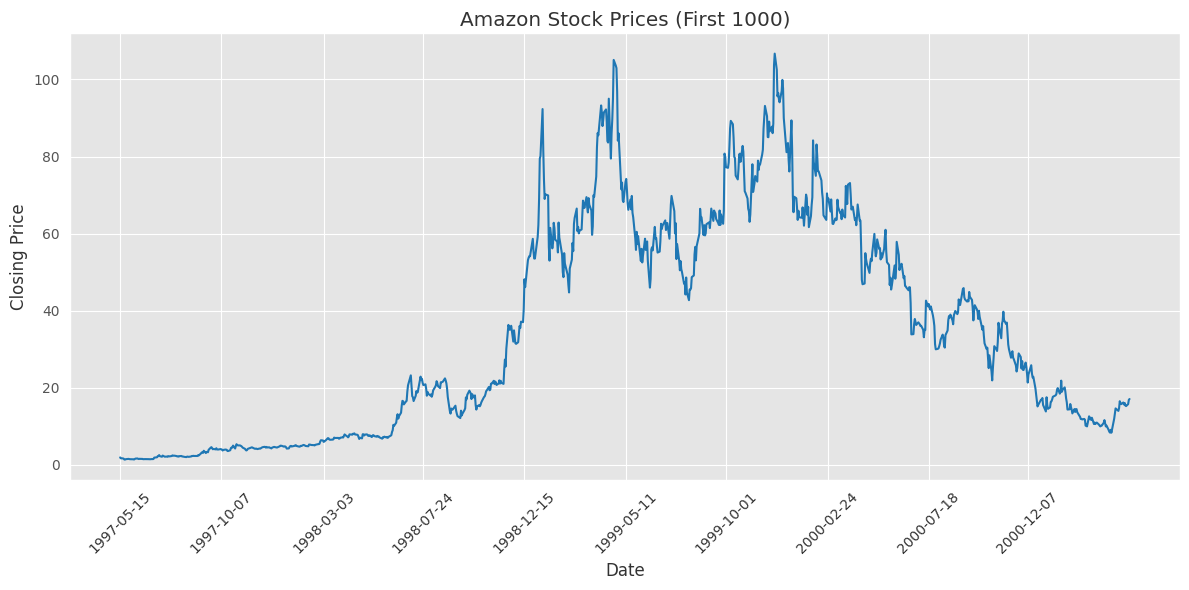

In [13]:
background_color = '#ffffff' 
plot_color = '#1f77b4'
title_color = '#333333' 
label_color = '#333333' 
secondary_color = '#ff7f0e' 

plt.figure(figsize=(12, 6), facecolor=background_color)
plt.plot(df['Date'][:1000], df['Close'][:1000], color=plot_color)
plt.title('Amazon Stock Prices (First 1000)', color=title_color)
plt.xlabel('Date', color=label_color)
plt.ylabel('Closing Price', color=label_color)
plt.xticks(df['Date'][:1000:100], rotation=45, color=label_color)
plt.tight_layout()
plt.show()


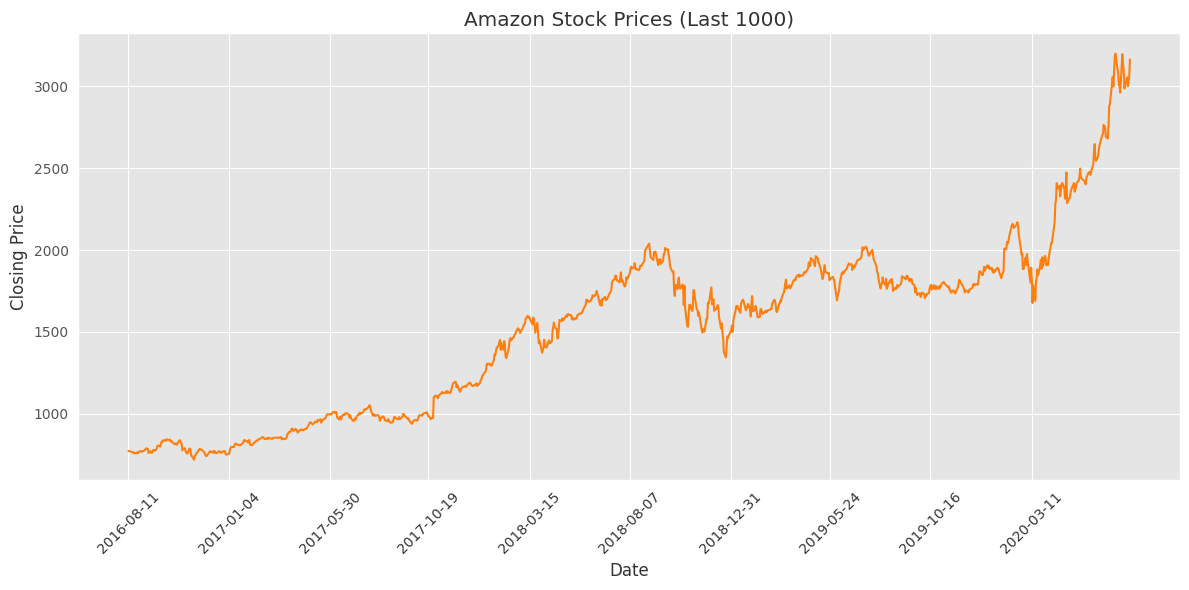

In [14]:
plt.figure(figsize=(12, 6), facecolor=background_color)
plt.plot(df['Date'][-1000:], df['Close'][-1000:], color=secondary_color)
plt.title('Amazon Stock Prices (Last 1000)', color=title_color)
plt.xlabel('Date', color=label_color)
plt.ylabel('Closing Price', color=label_color)
plt.xticks(df['Date'][-1000::100], rotation=45, color=label_color)
plt.tight_layout()
plt.show()

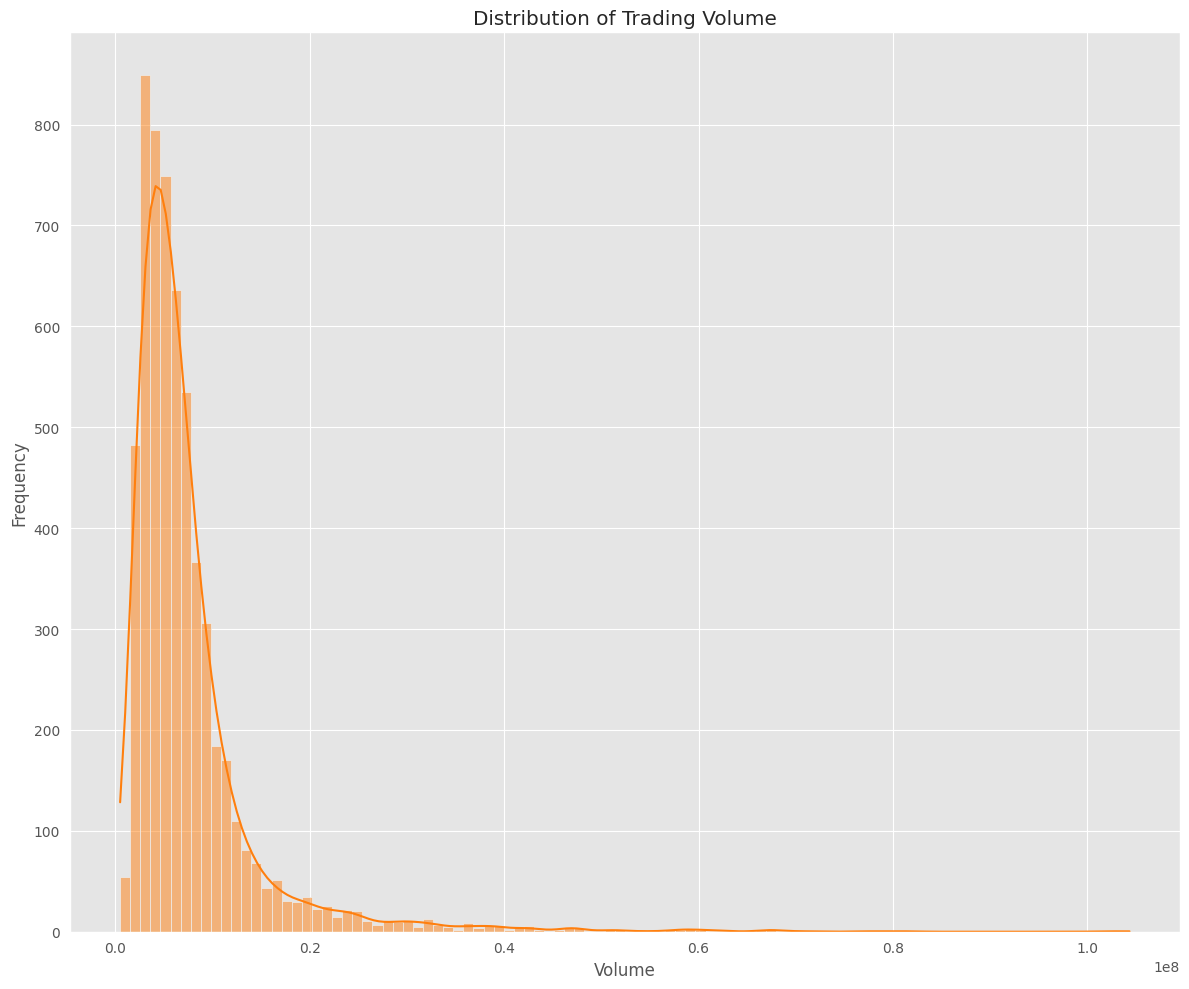

In [15]:
plt.figure(figsize=(12, 10))
sns.histplot(df['Volume'], bins=100, kde=True, color=secondary_color)
plt.title('Distribution of Trading Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [16]:
df_tsd = df.sort_values(by='Date')


df_tsd.set_index('Date', inplace=True)
fig = make_subplots(rows=4, cols=1, subplot_titles=('Open', 'High', 'Low', 'Close'))

fig.add_trace(
    go.Scatter(x=df_tsd.index, y=df['Open'], mode='lines', name='Open'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_tsd.index, y=df['High'], mode='lines', name='High'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df_tsd.index, y=df['Low'], mode='lines', name='Low'),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=df_tsd.index, y=df_tsd['Close'], mode='lines', name='Close'),
    row=4, col=1
)

fig.update_layout(height=1400, width=1000, title_text="OHLC Line Plots")

fig.show()


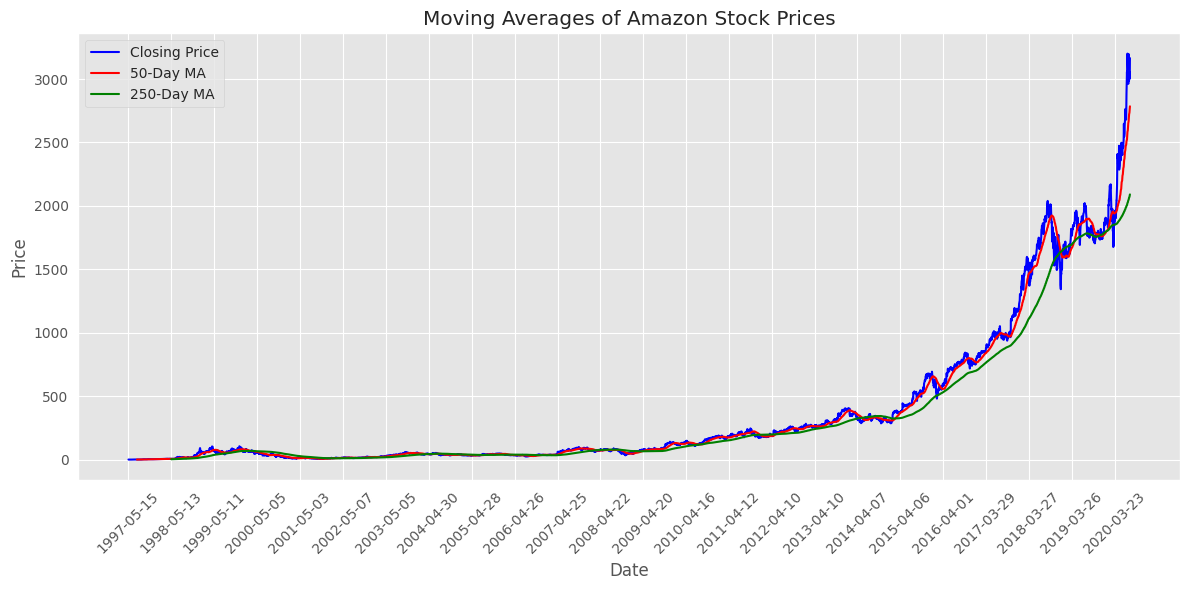

In [17]:
df['Mov_Av_50'] = df['Adj Close'].rolling(window=50).mean()
df['Mov_Av_250'] = df['Adj Close'].rolling(window=250).mean()
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], color='b', label='Closing Price')
plt.plot(df['Date'], df['Mov_Av_50'], color='r', label='50-Day MA')
plt.plot(df['Date'], df['Mov_Av_250'], color='g', label='250-Day MA')
plt.title('Moving Averages of Amazon Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(df['Date'][::250], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

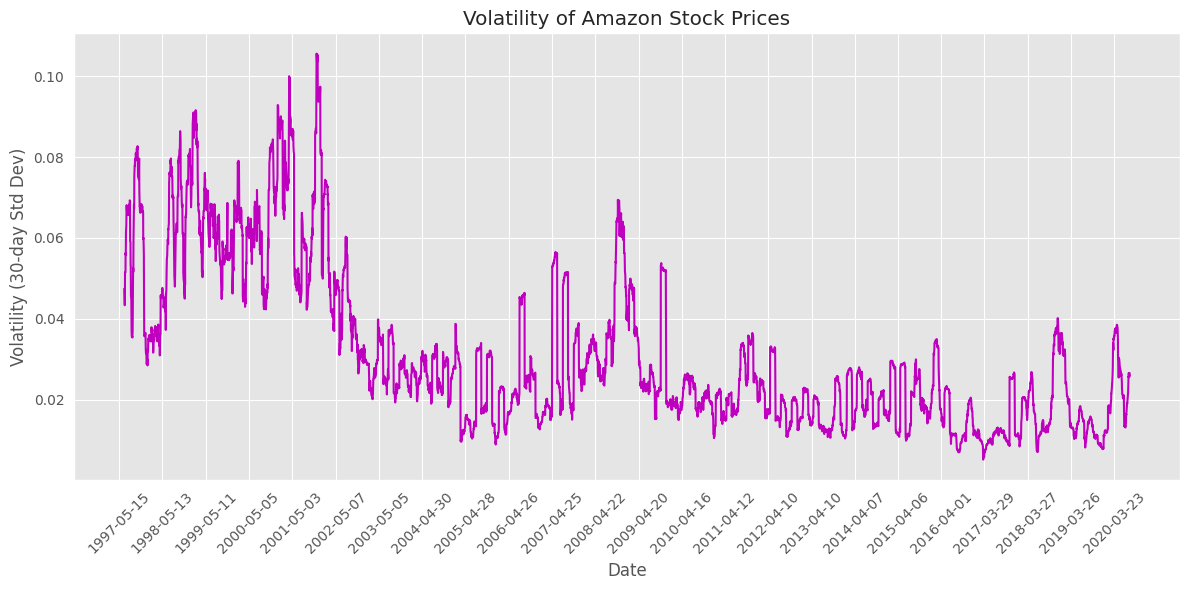

In [18]:
df['Daily_Return'] = df['Close'].pct_change()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Daily_Return'].rolling(window=30).std(), color='m')
plt.title('Volatility of Amazon Stock Prices')
plt.xlabel('Date')
plt.ylabel('Volatility (30-day Std Dev)')
plt.xticks(df['Date'][::250], rotation=45)
plt.tight_layout()
plt.show()

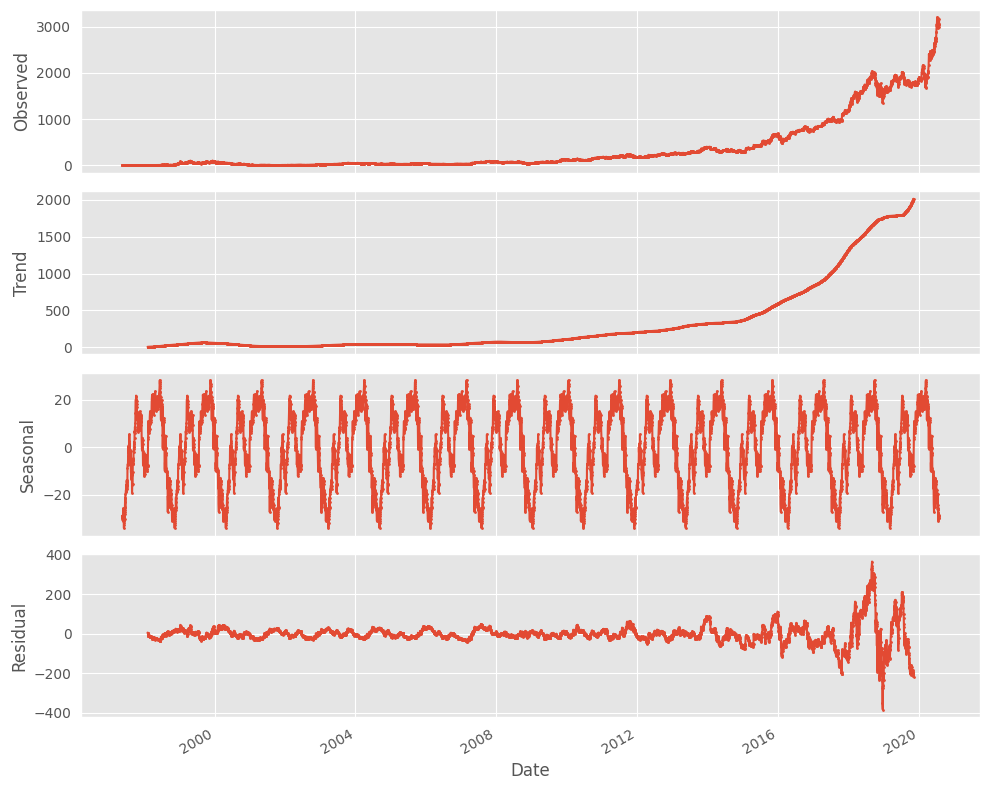

In [19]:
decomposition = seasonal_decompose(df_tsd['Adj Close'], model='additive', period=365)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8), sharex=True)

decomposition.observed.plot(ax=axes[0], marker='o', markersize=1)
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], marker='o', markersize=1)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], marker='o', markersize=1)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], marker='o', markersize=1) 
axes[3].set_ylabel('Residual')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [20]:
fig = px.line(df, x=df.Date, y=["High", "Low"], title='Daily High & Low for Amazon Stocks')
fig.update_layout(title=dict(text="Daily High-Low",font=dict(size=18)))
fig.show()

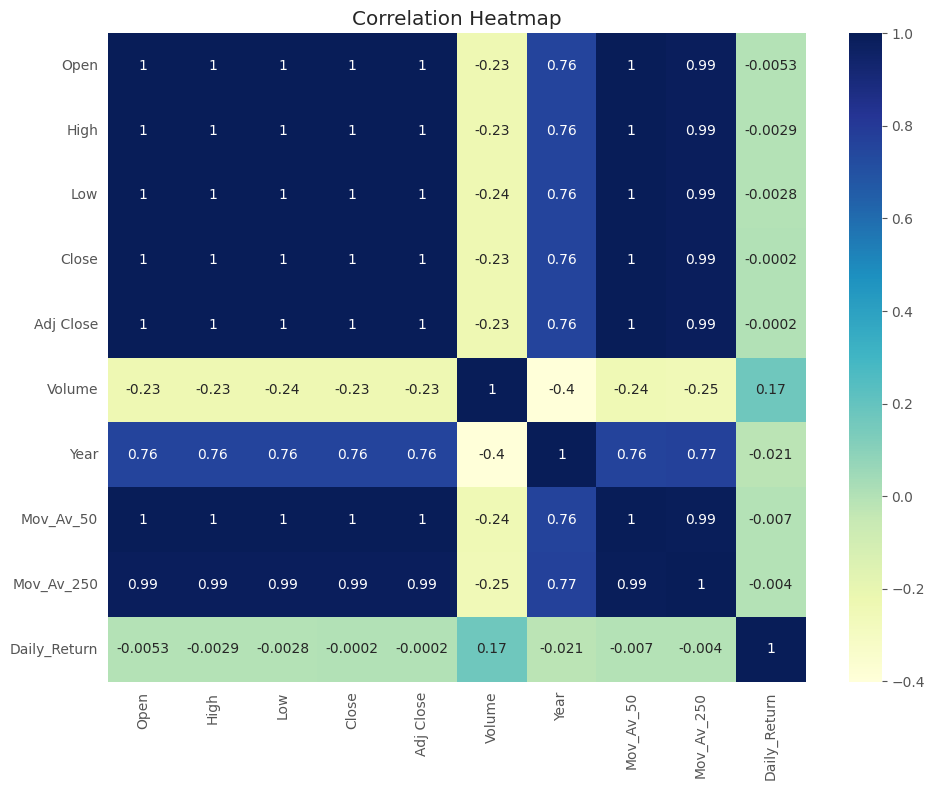

In [21]:
df_wo_date = df.drop(columns=['Date'])
 
correlation_matrix = df_wo_date.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

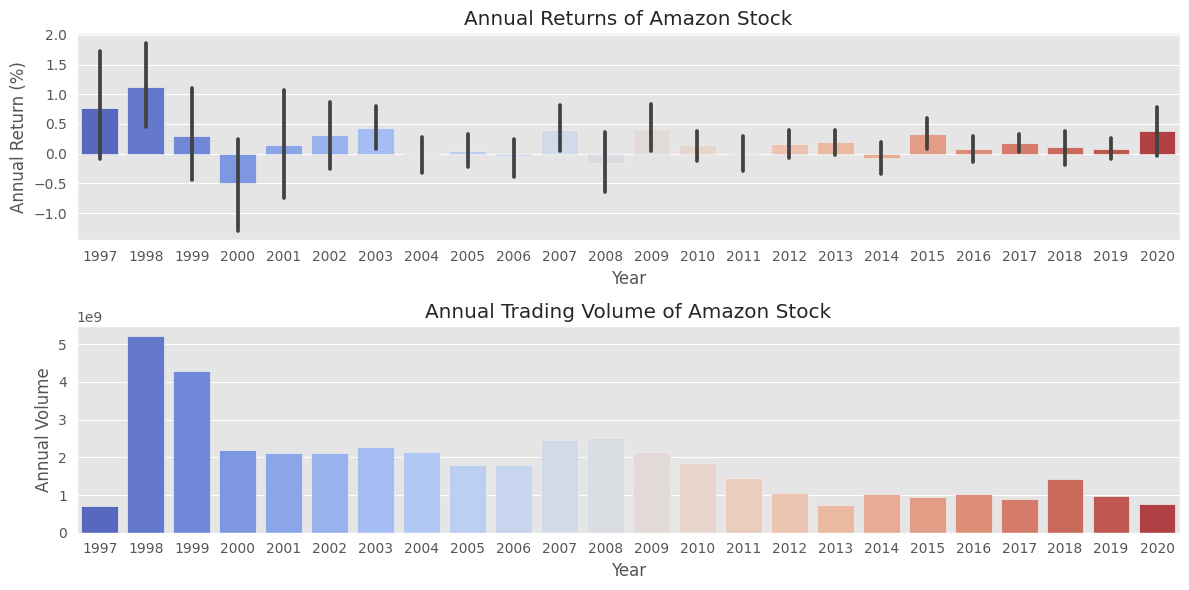

In [22]:
df['Annual_Return'] = df.groupby('Year')['Adj Close'].pct_change() * 100

df['Annual_Volume'] = df.groupby('Year')['Volume'].transform('sum')

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
sns.barplot(data=df, x='Year', y='Annual_Return', palette='coolwarm')
plt.title('Annual Returns of Amazon Stock')
plt.xlabel('Year')
plt.ylabel('Annual Return (%)')

plt.subplot(2, 1, 2)
sns.barplot(data=df, x='Year', y='Annual_Volume', palette='coolwarm')
plt.title('Annual Trading Volume of Amazon Stock')
plt.xlabel('Year')
plt.ylabel('Annual Volume')
plt.tight_layout()
plt.show()

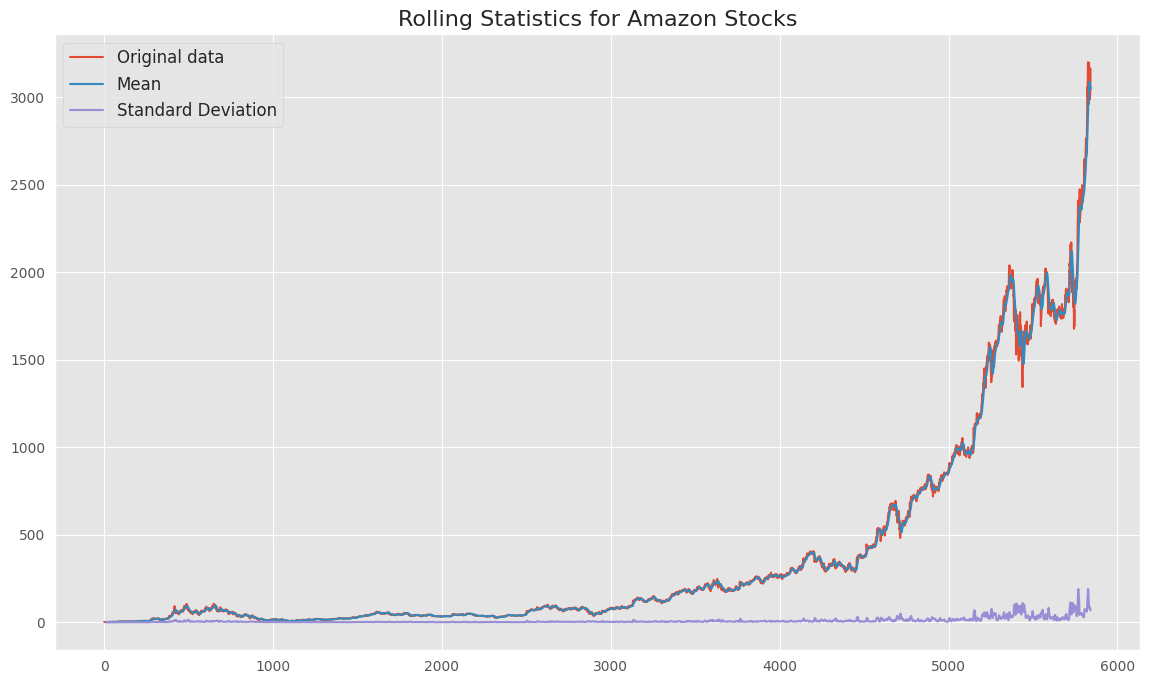

In [23]:
close_values = df['Close']

rM = close_values.rolling(12).mean() 
rS = close_values.rolling(12).std()

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(close_values, label= 'Original data')
ax.plot(rM, label='Mean')
ax.plot(rS, label='Standard Deviation')
plt.title('Rolling Statistics for Amazon Stocks', fontsize=16)
ax.legend(fontsize=12)
plt.show()

# Models

## SARIMA

In [24]:
close_values = df[["Date", "Close"]].copy()
close_values["Date"] = pd.to_datetime(close_values["Date"])
close_values.set_index("Date", inplace = True)

In [25]:
close_values = close_values.asfreq("d")
close_values=close_values.fillna(method  = "bfill")

In [26]:
result = adfuller(close_values)

print("ADF Test Statistic: ", result[0])
print("p-value: ", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"{key}: {value}")

if result[1] < 0.05:
    print("Residuals are stationary.")
else:
    print("Residuals are not stationary.")

ADF Test Statistic:  5.773923749756862
p-value:  1.0
Critical Values:
1%: -3.431124850687746
5%: -2.8618824309525883
10%: -2.5669522711136055
Residuals are not stationary.


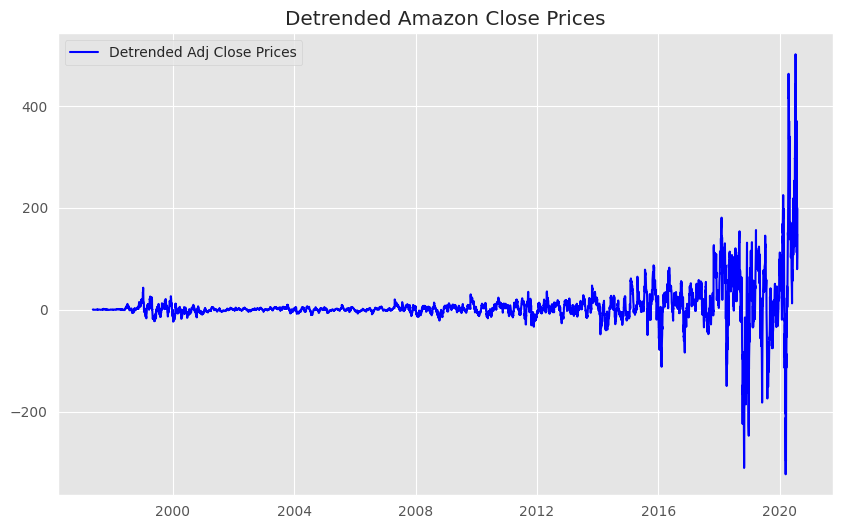

In [27]:
close_prices = df['Close']

moving_avg = close_prices.rolling(window=30).mean().fillna(method  = "bfill")
detrended_close = close_prices - moving_avg
detrended_for_plot_df = pd.DataFrame({'Date': df['Date'], 'Detrended Close': detrended_close})


plt.figure(figsize=(10,6))
plt.plot(detrended_for_plot_df['Date'], detrended_for_plot_df['Detrended Close'], 'blue', label='Detrended Adj Close Prices')
plt.title('Detrended Amazon Close Prices')
plt.legend()
plt.show()


In [28]:
result = adfuller(detrended_for_plot_df['Detrended Close'])

print("ADF Test Statistic: ", result[0])
print("p-value: ", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"{key}: {value}")

if result[1] < 0.05:
    print("Residuals are stationary.")
else:
    print("Residuals are not stationary.")

ADF Test Statistic:  -6.197902234735213
p-value:  5.9037296075068205e-08
Critical Values:
1%: -3.431476604615945
5%: -2.8620378526446375
10%: -2.567035004946881
Residuals are stationary.


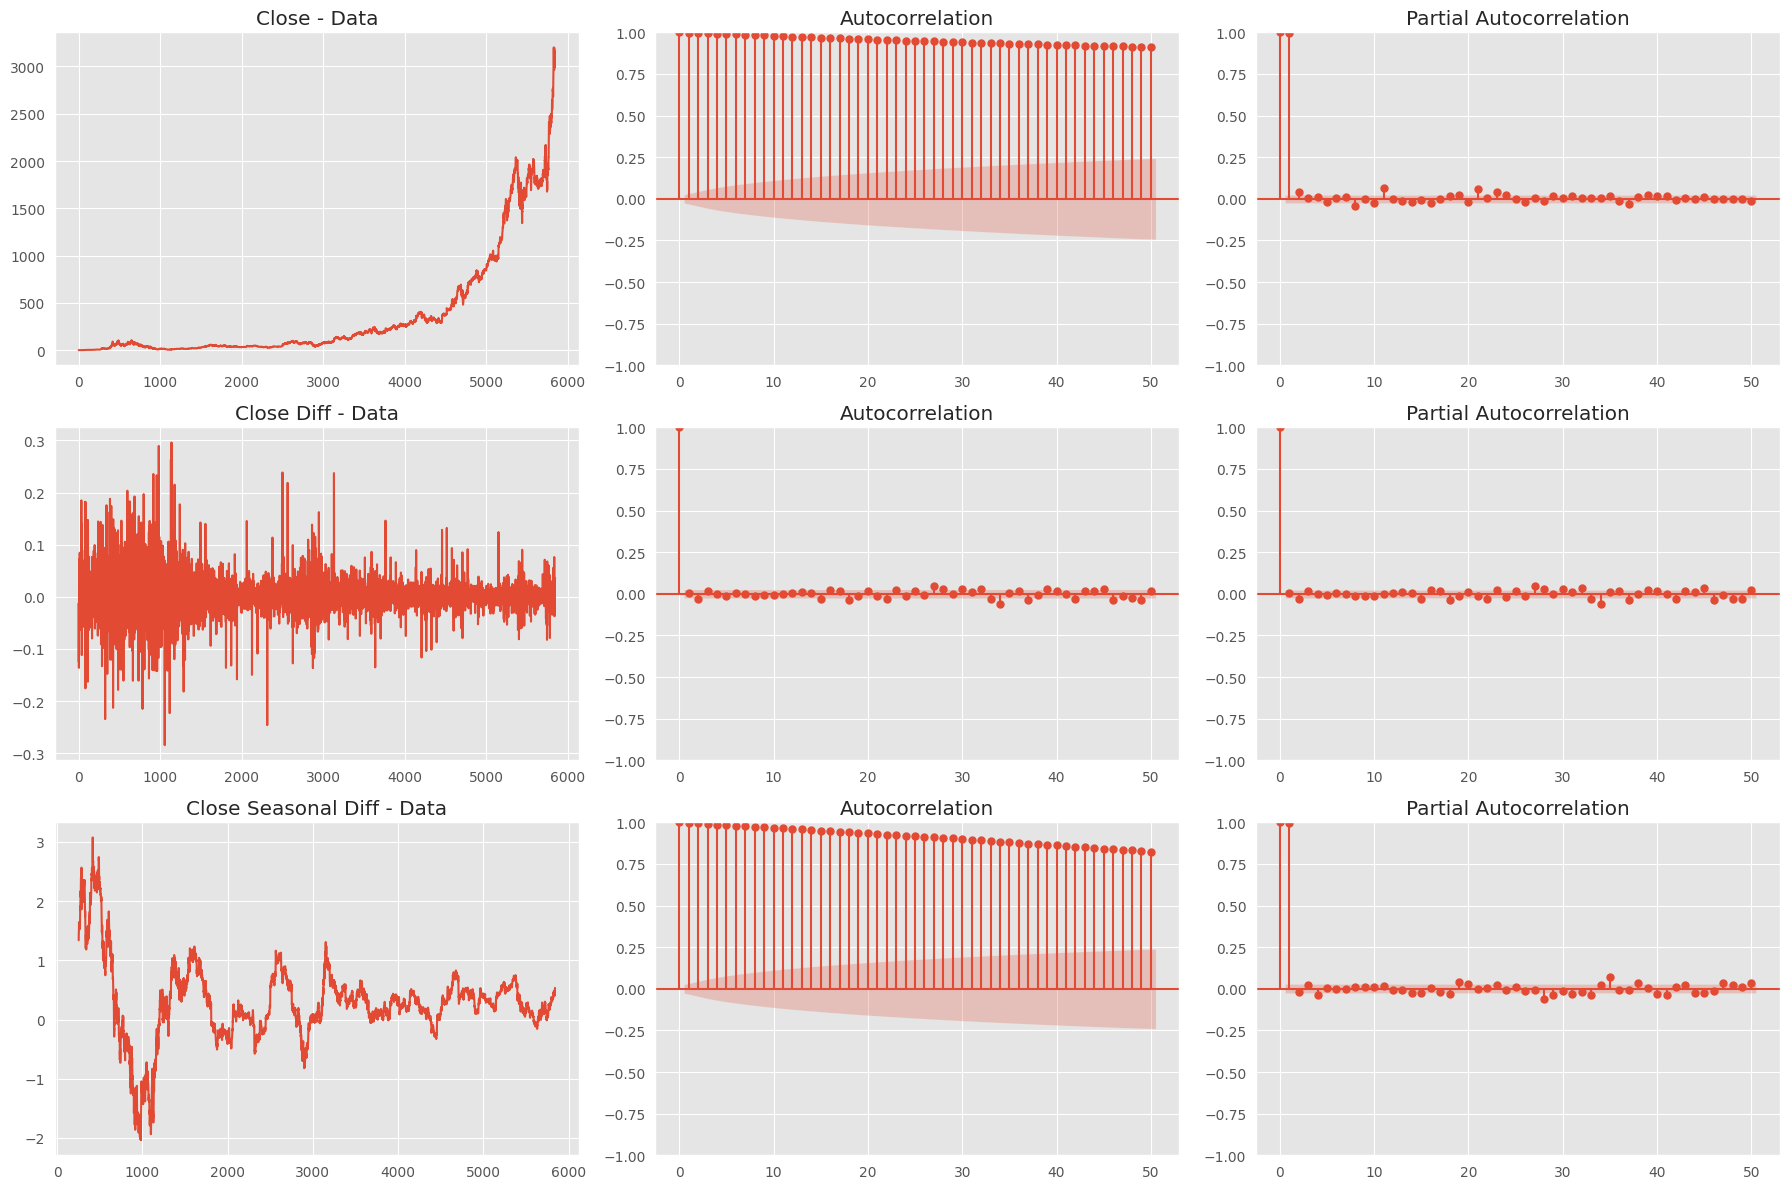

In [29]:
close_log = np.log(df['Close'])
close_diff = close_log - close_log.shift(1)
close_diff = close_diff.dropna() 
close_seasonal_diff = close_log - close_log.shift(252) 
close_seasonal_diff = close_seasonal_diff.dropna()

fig, axs = plt.subplots(3, 3, figsize=(18, 12))

axs[0, 0].plot(df['Close'])
axs[0, 0].set_title('Close - Data')
axs[0, 1].set_title('ACF - Close')
plot_acf(df['Close'], ax=axs[0, 1], lags=50)
axs[0, 2].set_title('PACF - Close')
plot_pacf(df['Close'], ax=axs[0, 2], lags=50)

axs[1, 0].plot(close_diff)
axs[1, 0].set_title('Close Diff - Data')
axs[1, 1].set_title('ACF - Close Diff')
plot_acf(close_diff, ax=axs[1, 1], lags=50)
axs[1, 2].set_title('PACF - Close Diff')
plot_pacf(close_diff, ax=axs[1, 2], lags=50)

axs[2, 0].plot(close_seasonal_diff)
axs[2, 0].set_title('Close Seasonal Diff - Data')
axs[2, 1].set_title('ACF - Close Seasonal Diff')
plot_acf(close_seasonal_diff, ax=axs[2, 1], lags=50)
axs[2, 2].set_title('PACF - Close Seasonal Diff')
plot_pacf(close_seasonal_diff, ax=axs[2, 2], lags=50)

plt.tight_layout()
plt.show()


In [30]:
length = int((len(close_values)*9)/10) 
train = close_values[:length]
test = close_values[length:]

modelValid =  pm.auto_arima(train,
                       seasonal=True, m=7,
                       test='adf',
                       max_p=2, max_q=2,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True)

print(modelValid.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=46684.664, Time=31.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=46745.216, Time=0.16 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=46733.081, Time=3.04 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=46733.587, Time=3.13 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=46753.491, Time=0.13 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=46684.655, Time=22.75 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=46682.760, Time=6.47 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=46684.651, Time=25.87 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=46738.822, Time=4.42 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=46739.147, Time=2.82 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=46738.272, Time=0.70 sec
 ARIMA(2,1,2)(0,0,0)[7]             : AIC=46690.493, Time=4.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[7] intercept
Total fit time: 104.789 seconds
                               SARIMAX Results                         

In [31]:
forecast_result = modelValid.predict(n_periods=len(test))
forecast_series = pd.Series(forecast_result, index=test.index)

print(forecast_series.head())

Date
2018-04-06    1453.705268
2018-04-07    1452.099691
2018-04-08    1452.290892
2018-04-09    1454.003199
2018-04-10    1452.921958
Freq: D, dtype: float64


Text(0, 0.5, 'close Price')

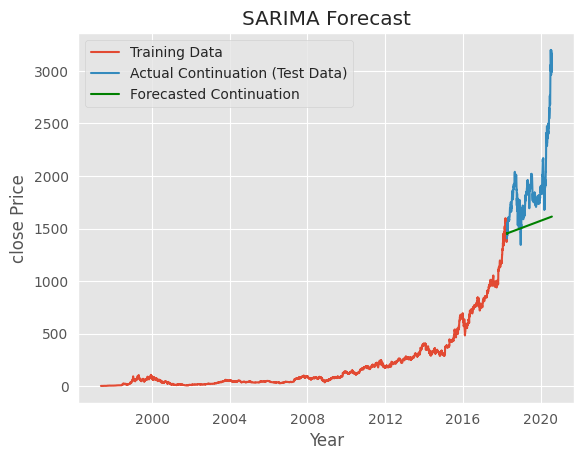

In [32]:
plt.plot(train,label = "Training Data") 
plt.plot(test,label = "Actual Continuation (Test Data)")
plt.plot(forecast_series,label = "Forecasted Continuation", color = "g")

plt.title("SARIMA Forecast")
plt.legend(loc = "upper left") 
plt.xlabel("Year") 
plt.ylabel("close Price")

In [33]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
future_forecast = pd.DataFrame({'Prediction': forecast_series})


### Metrics

In [34]:
def calculate_bias(actual, predicted):
    forecast_errors = actual - predicted
    bias = forecast_errors.mean()
    return bias

bias_sarima = calculate_bias(df_test.values, future_forecast['Prediction'].values)
print(f'Bias: {bias_sarima:.6f}')

Bias: 360.677913


In [35]:
r2_sarima = r2_score(df_test, future_forecast['Prediction'])
print(f'R^2 Score: {r2_sarima:.4f}')

R^2 Score: -0.9719


In [36]:
mae_sarima = mean_absolute_error(df_test, future_forecast['Prediction'])
print(f'MAE: {mae_sarima:.4f}')

MAE: 363.2290


In [37]:
def mean_absolute_percentage_error(df_test, future_forecast):
    df_test, future_forecast = np.array(df_test), np.array(future_forecast)
    return np.mean(np.abs((df_test - future_forecast) / df_test)) * 100

mape_sarima = mean_absolute_percentage_error(df_test, future_forecast)
print(f'MAPE: {mape_sarima:.4f}')

MAPE: 17.4131


In [38]:
model_names = ['SARIMA']
mae_value = mae_sarima
mape_value = mape_sarima
r2_value = r2_sarima

metrics_df = pd.DataFrame({
    'Model': model_names,
    'MAE': mae_value,
    'MAPE': mape_value,
    'R^2': r2_value
})


## Random Forest Regressor

In [39]:
df = pd.read_csv(file_path)

In [40]:
df.head()

Date      Open      High       Low     Close  Adj Close    Volume
0  1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1  1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
2  1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
3  1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
4  1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200

In [41]:
train_df = df.dropna()
X = train_df.drop(columns=['Date', 'Close'])
y = train_df['Close']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [10, 20, 30],       
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]    
}


In [43]:
rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: 0.9999450760475425


In [44]:
y_pred = best_rf_model.predict(X_test)

### Metrics

In [45]:
print('Random Forest Regressor Train Score is : ', best_rf_model.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ', best_rf_model.score(X_test, y_test))

Random Forest Regressor Train Score is :  0.9999959119109881
Random Forest Regressor Test Score is :  0.9999835467511012


In [46]:
mae_rf = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae_rf:.4f}')

r2_rf = r2_score(y_test, y_pred)
print(f'R² Score: {r2_rf:.4f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0 
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

mape_rf = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape_rf:.4f}')


Mean Absolute Error: 0.5466
R² Score: 1.0000
Mean Absolute Percentage Error (MAPE): 0.1549


In [47]:
new_model = 'Random Forest Regressor'
new_mae = mae_rf
new_mape = mape_rf
new_r2 = r2_rf

new_data = pd.DataFrame({
    'Model': [new_model],
    'MAE': [new_mae],
    'MAPE': [new_mape],
    'R^2': [new_r2]
})

metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)


## Prophet

In [48]:
df = pd.read_csv(file_path)

In [49]:
df.Date = pd.to_datetime(df.Date)
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [50]:
df.reset_index(inplace=True)

data=df[["Date","Close"]]

data.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)

data.head()

ds         y
0 1997-05-15  1.958333
1 1997-05-16  1.729167
2 1997-05-19  1.708333
3 1997-05-20  1.635417
4 1997-05-21  1.427083

In [51]:
df_train, df_test = train_test_split(data, test_size=0.20, random_state=42)


15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:32 - cmdstanpy - INFO - Chain [1] done processing


Feature: Open
             ds        yhat  yhat_lower  yhat_upper
4850 2016-06-03  514.603382  482.082163  550.123990
4851 2016-06-04  516.397253  484.457231  547.550433
4852 2016-06-05  516.669787  482.474189  547.689483
4853 2016-06-06  515.408974  482.234098  548.926467
4854 2016-06-07  515.423725  481.732025  549.143398


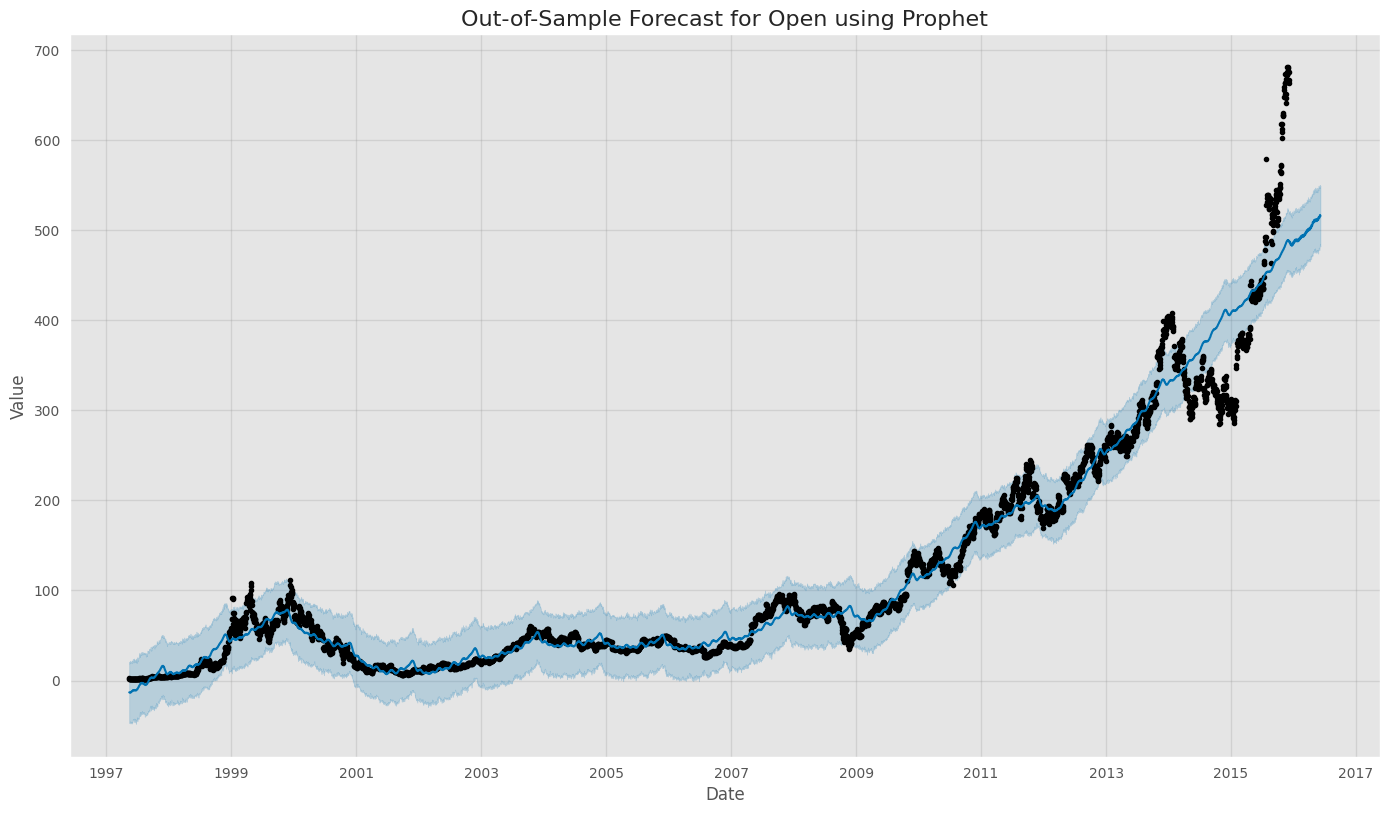

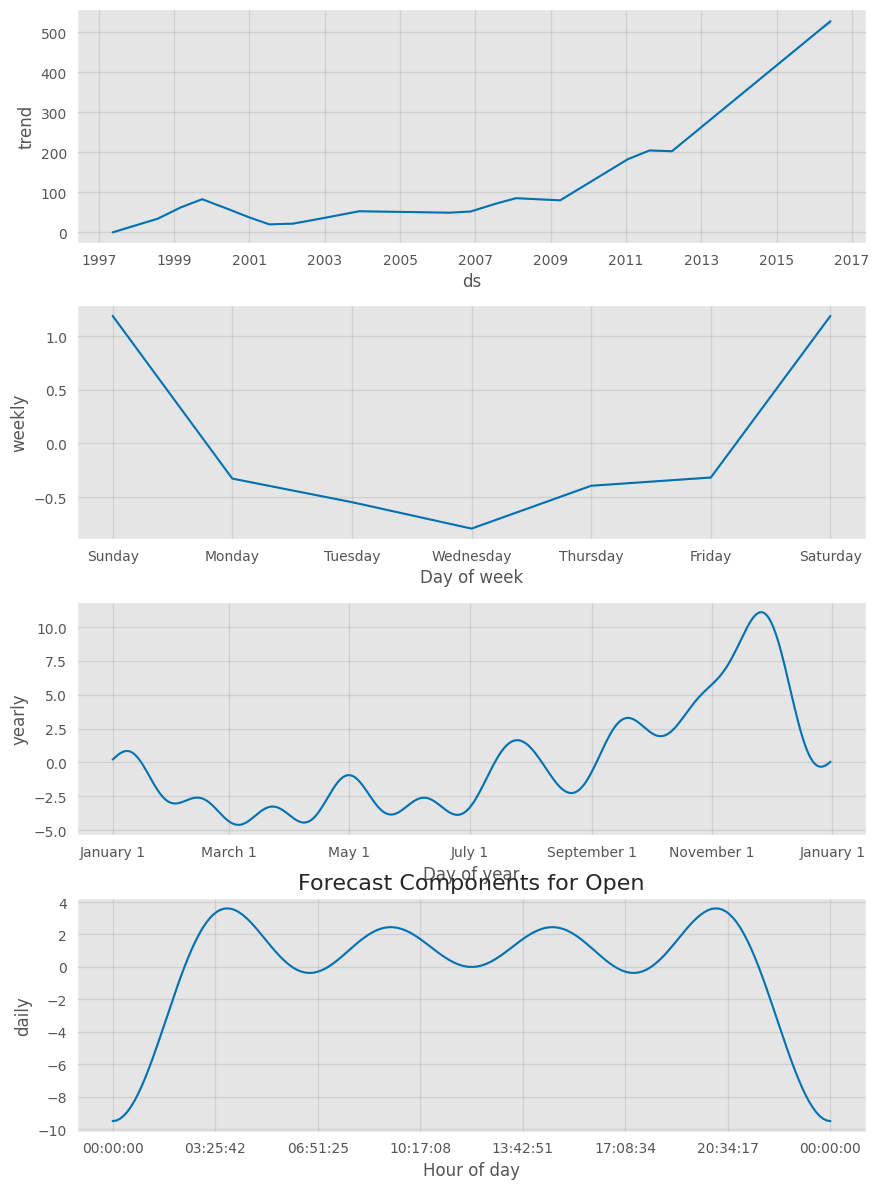

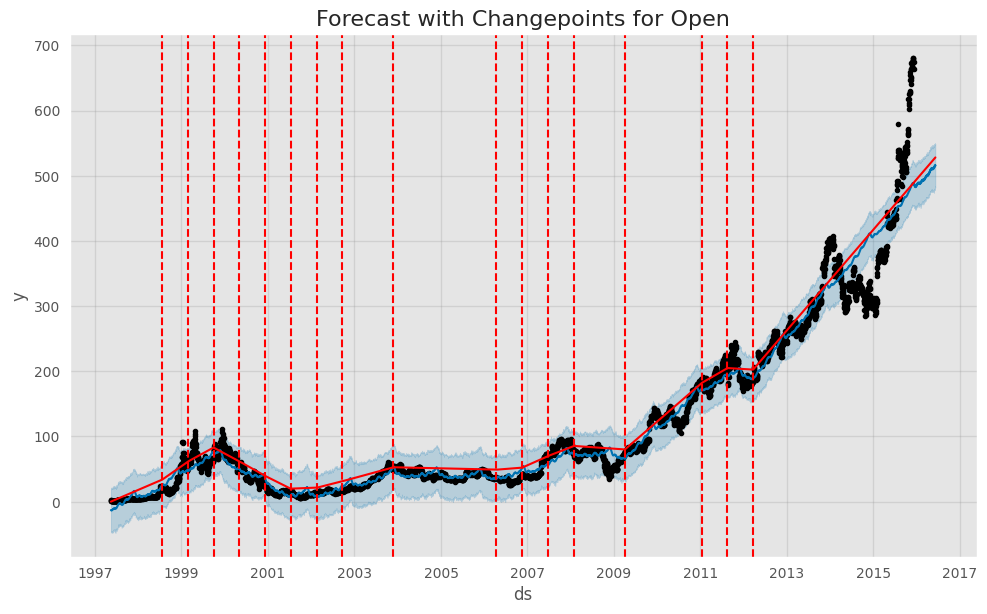

15:25:38 - cmdstanpy - INFO - Chain [1] start processing
15:25:41 - cmdstanpy - INFO - Chain [1] done processing


Feature: High
             ds        yhat  yhat_lower  yhat_upper
4850 2016-06-03  519.552809  484.309251  552.742432
4851 2016-06-04  521.297139  486.310289  557.289147
4852 2016-06-05  521.564277  486.174602  554.236537
4853 2016-06-06  520.292345  485.820568  552.584445
4854 2016-06-07  520.421675  486.168921  556.257015


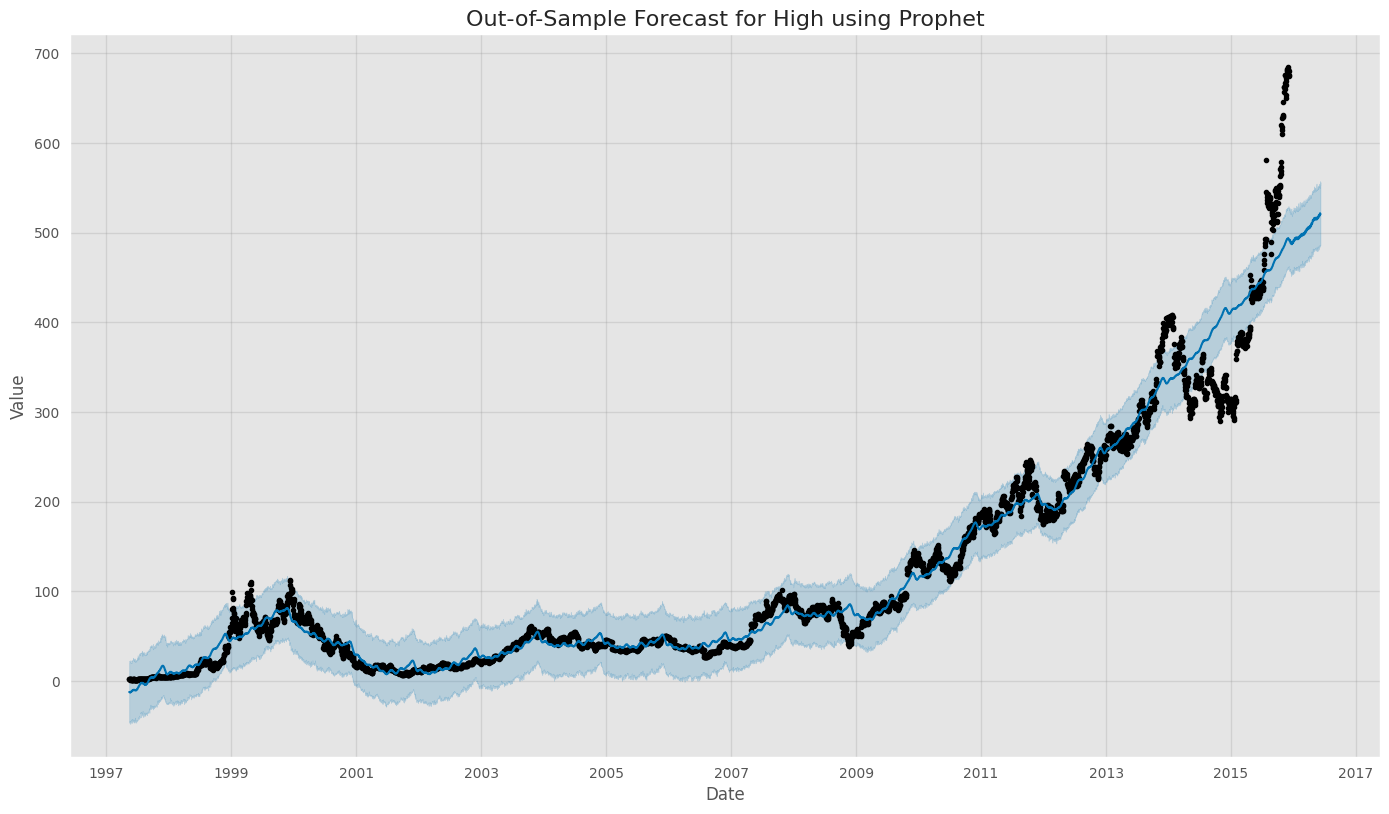

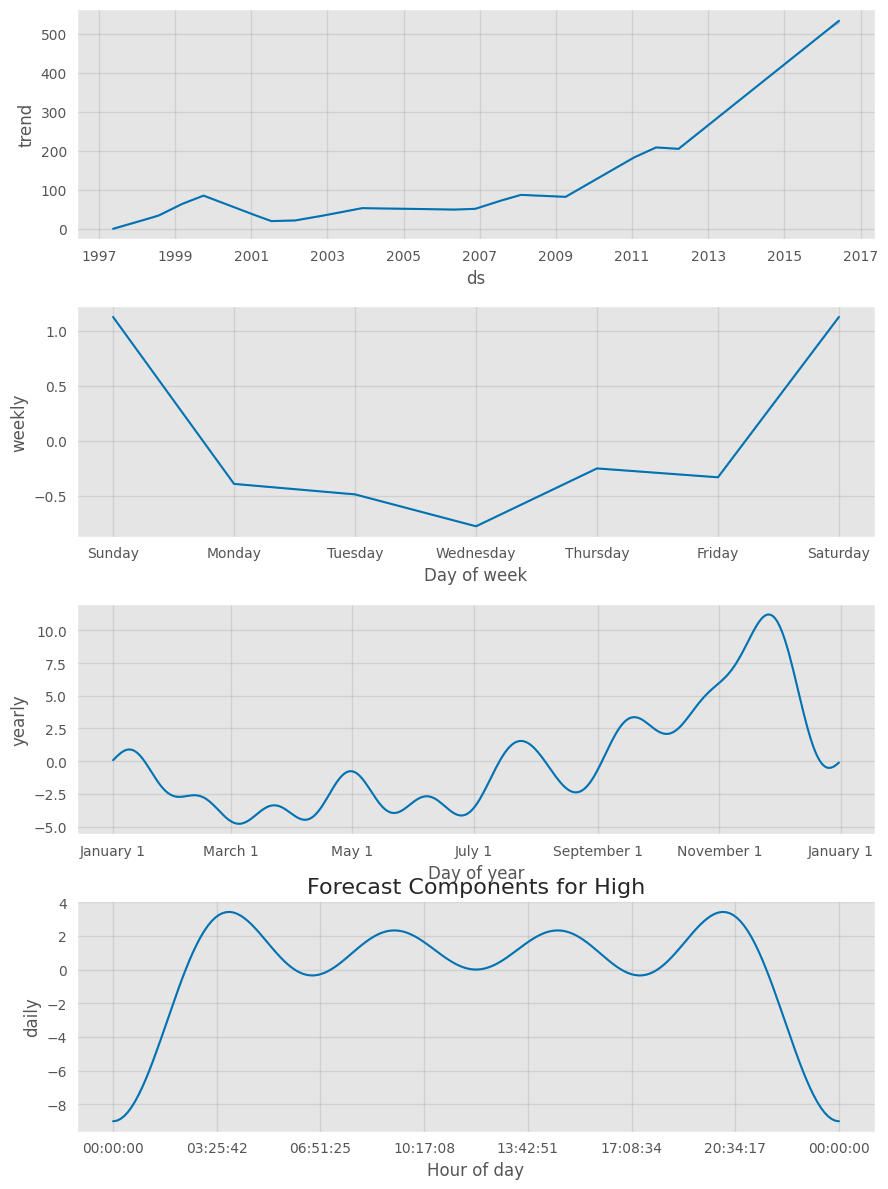

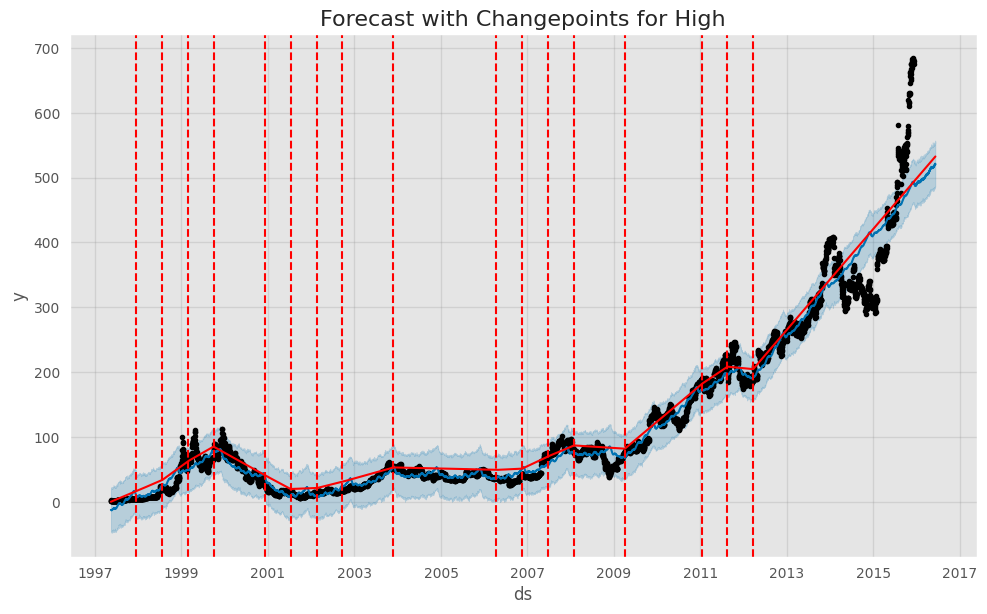

15:25:46 - cmdstanpy - INFO - Chain [1] start processing
15:25:47 - cmdstanpy - INFO - Chain [1] done processing


Feature: Low
             ds        yhat  yhat_lower  yhat_upper
4850 2016-06-03  508.753776  477.887628  542.176869
4851 2016-06-04  510.369184  475.085265  541.474496
4852 2016-06-05  510.620722  475.654762  541.094633
4853 2016-06-06  509.397567  475.193210  543.803372
4854 2016-06-07  509.481855  475.033512  544.769580


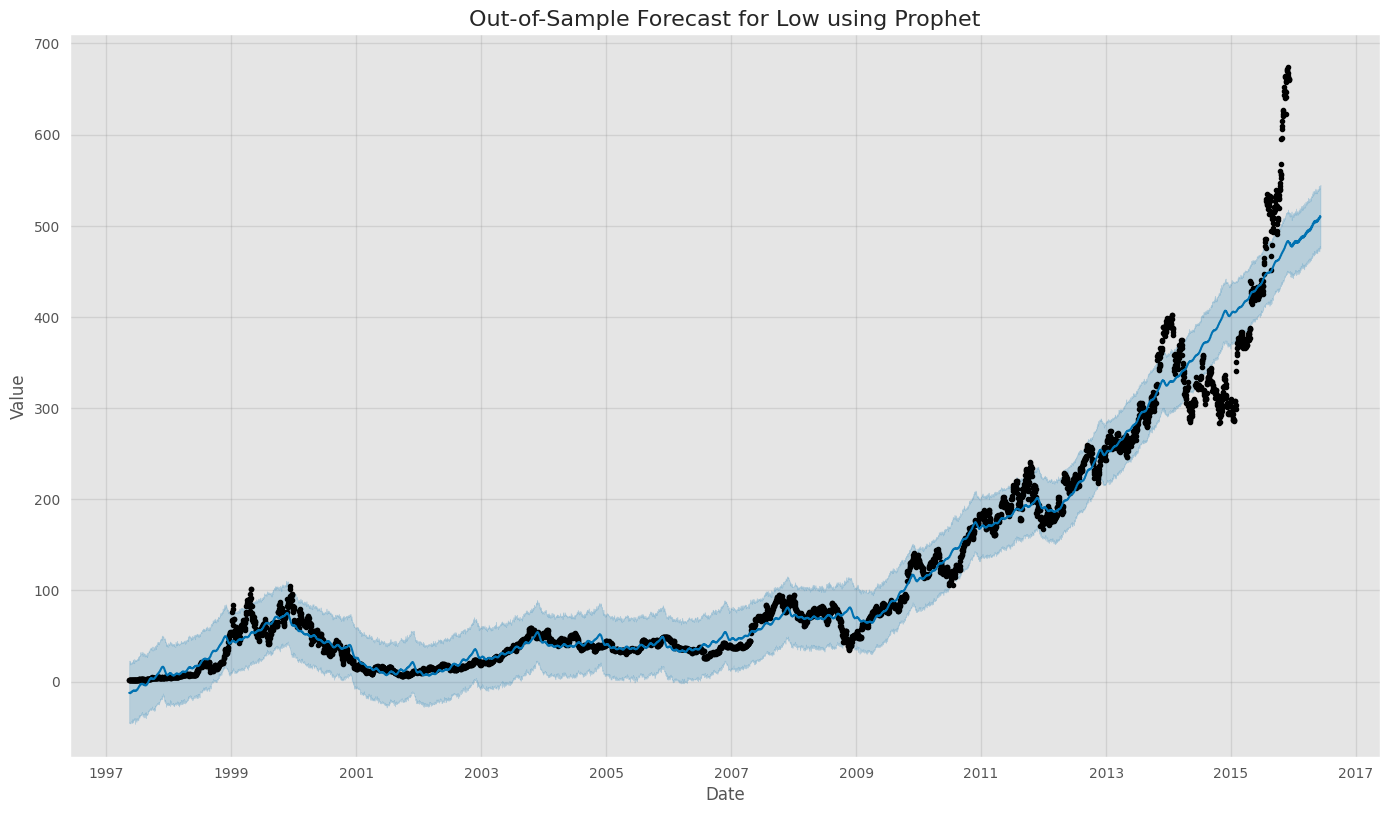

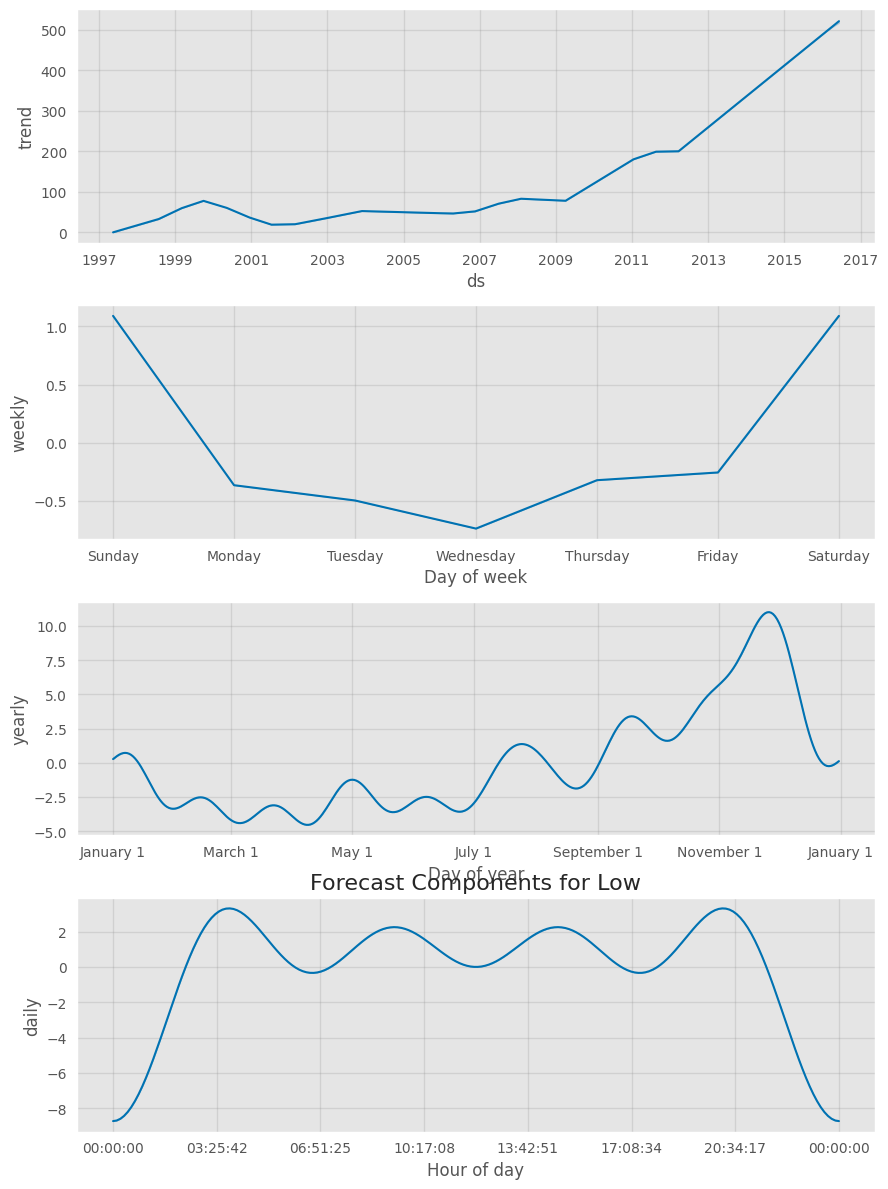

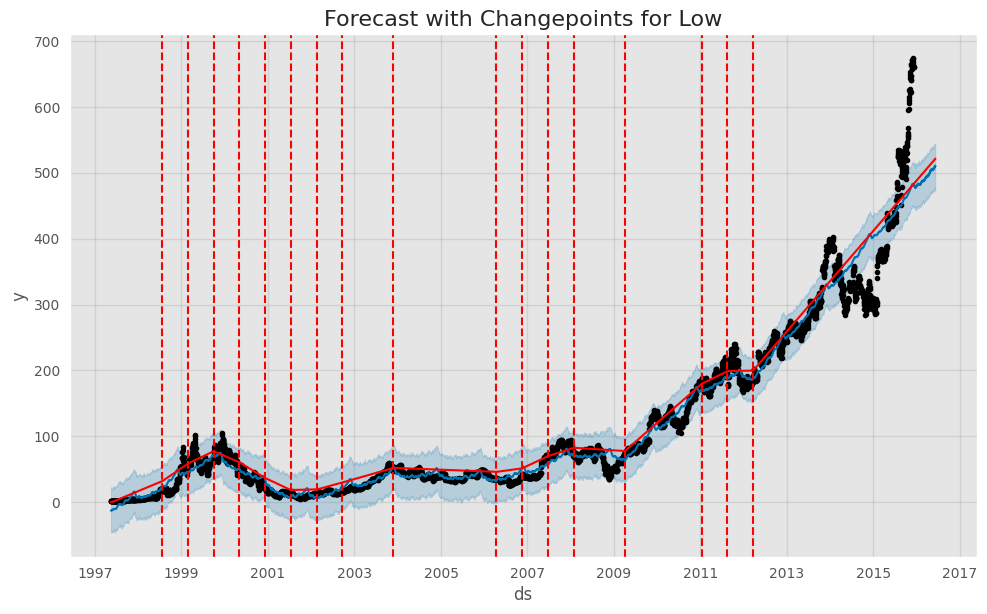

15:25:52 - cmdstanpy - INFO - Chain [1] start processing
15:25:54 - cmdstanpy - INFO - Chain [1] done processing


Feature: Close
             ds        yhat  yhat_lower  yhat_upper
4850 2016-06-03  514.137488  476.998866  546.577080
4851 2016-06-04  515.768131  482.033829  549.495155
4852 2016-06-05  516.004792  481.810558  549.948580
4853 2016-06-06  514.743761  480.481343  548.427170
4854 2016-06-07  514.881285  482.810334  548.265352


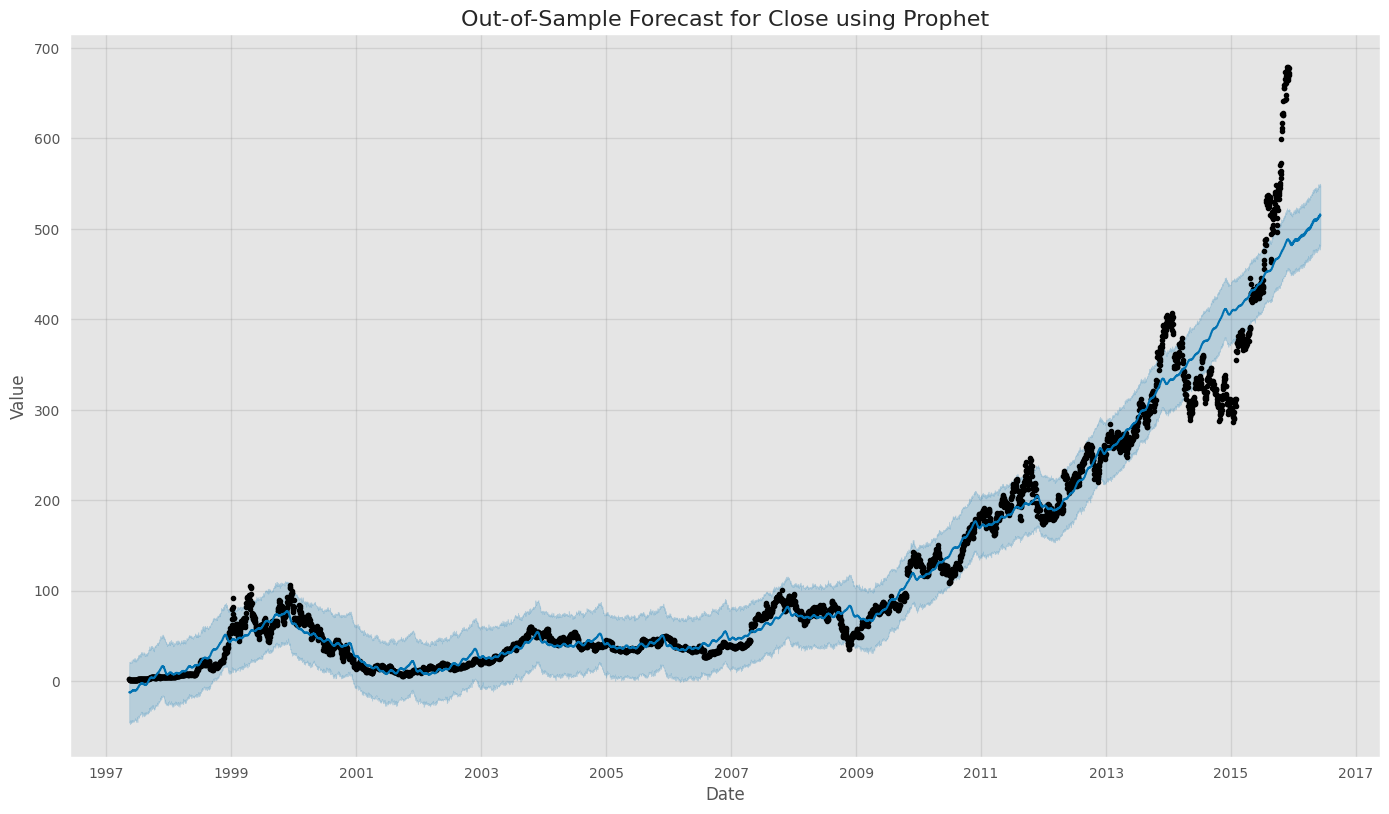

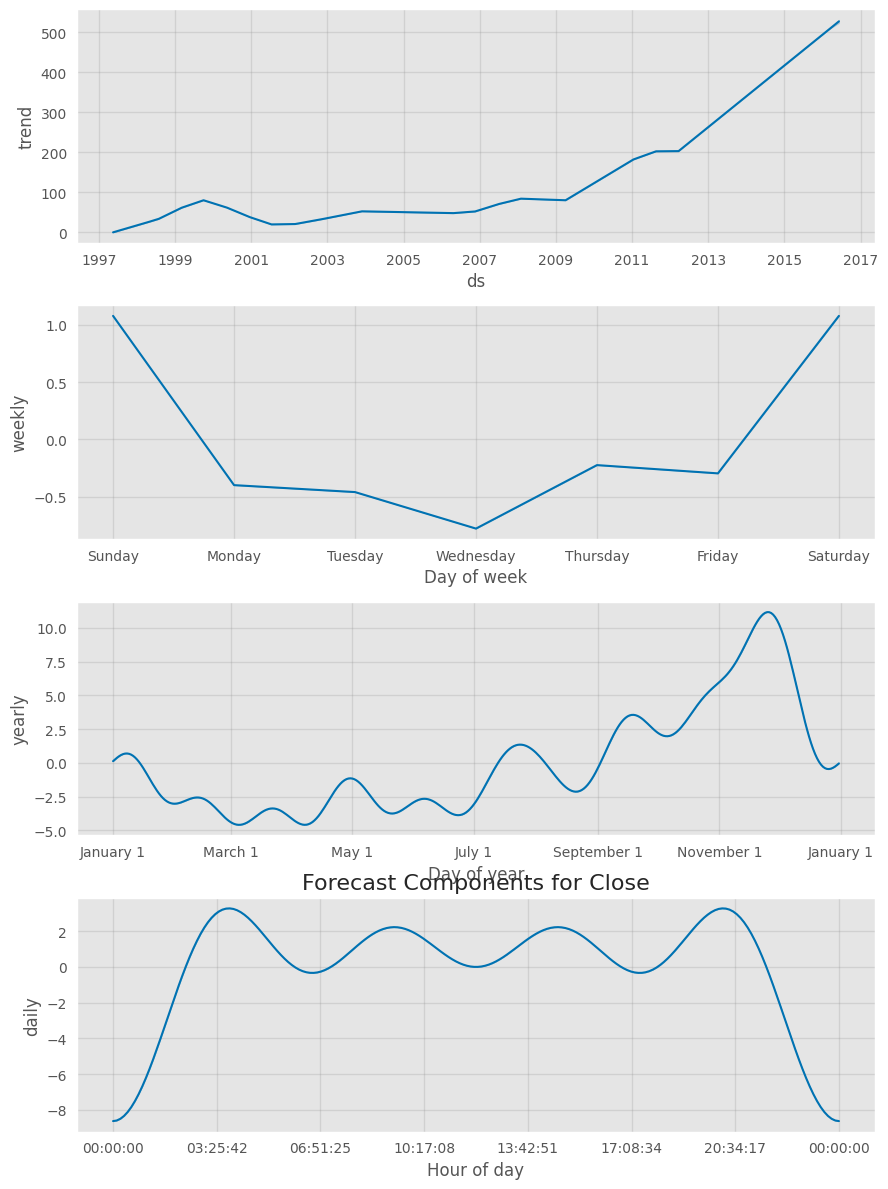

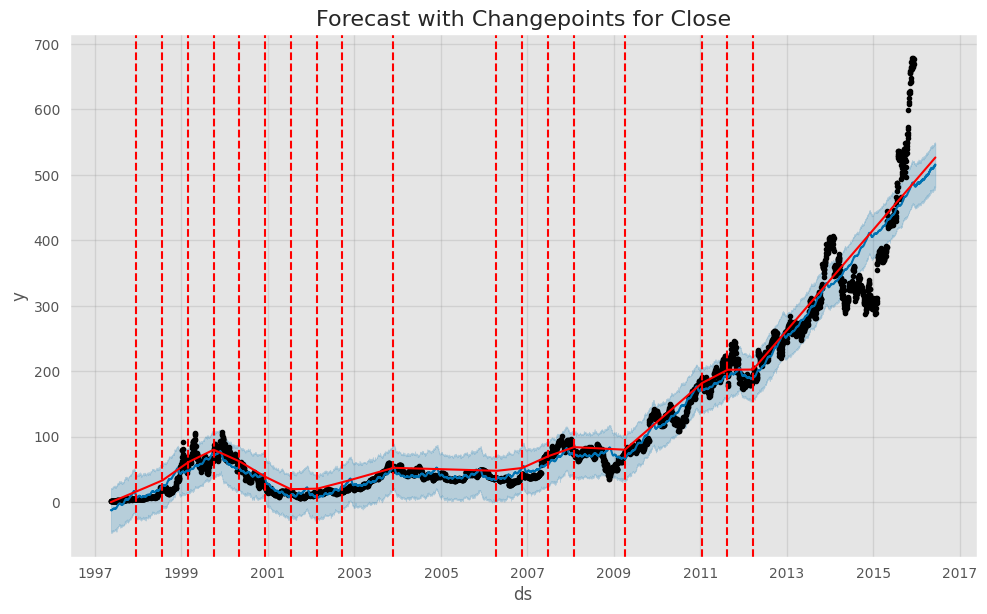

15:25:59 - cmdstanpy - INFO - Chain [1] start processing
15:26:01 - cmdstanpy - INFO - Chain [1] done processing


Feature: Adj Close
             ds        yhat  yhat_lower  yhat_upper
4850 2016-06-03  514.137488  477.186991  548.600877
4851 2016-06-04  515.768131  479.567916  551.827663
4852 2016-06-05  516.004792  482.245734  550.944533
4853 2016-06-06  514.743761  478.937208  551.107638
4854 2016-06-07  514.881285  481.946136  549.298695


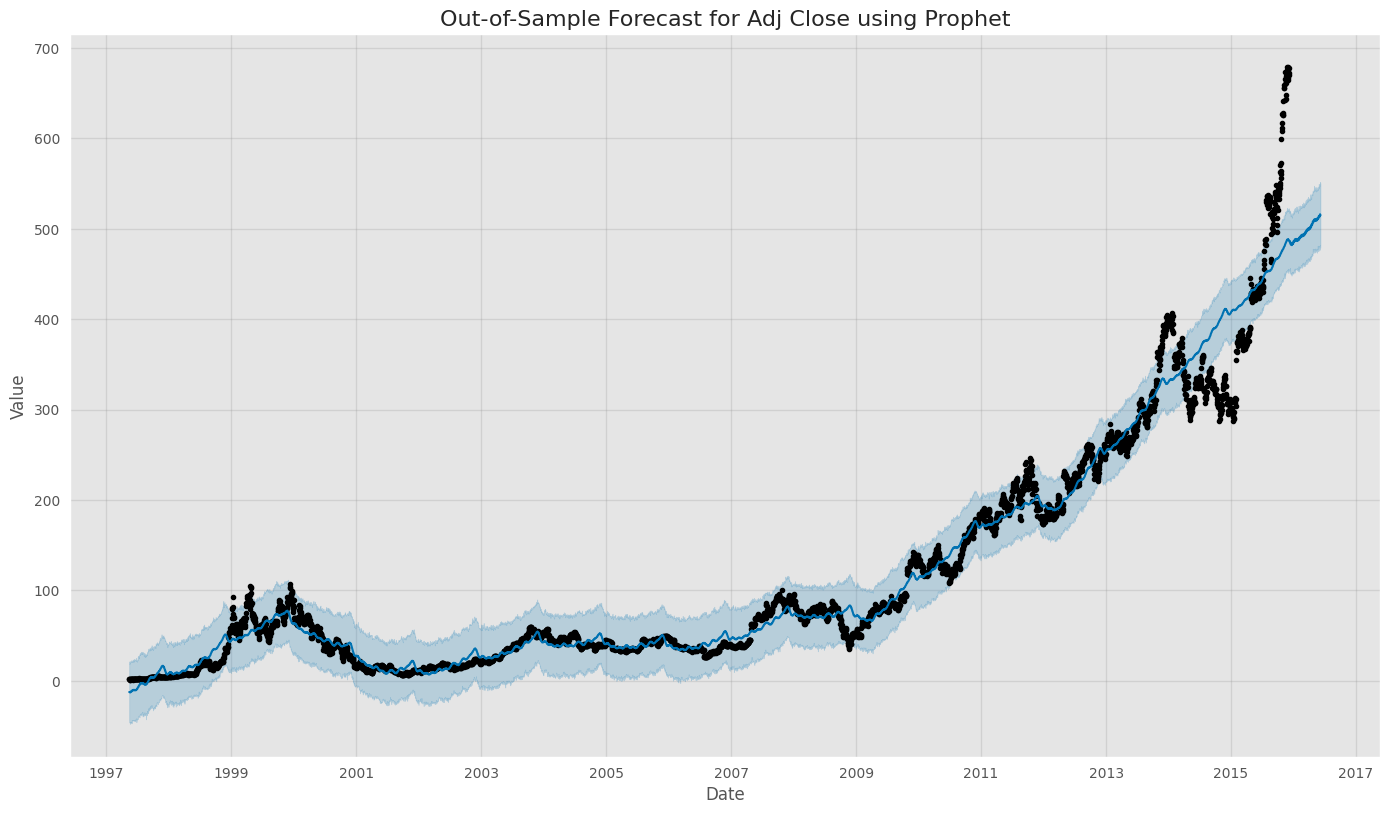

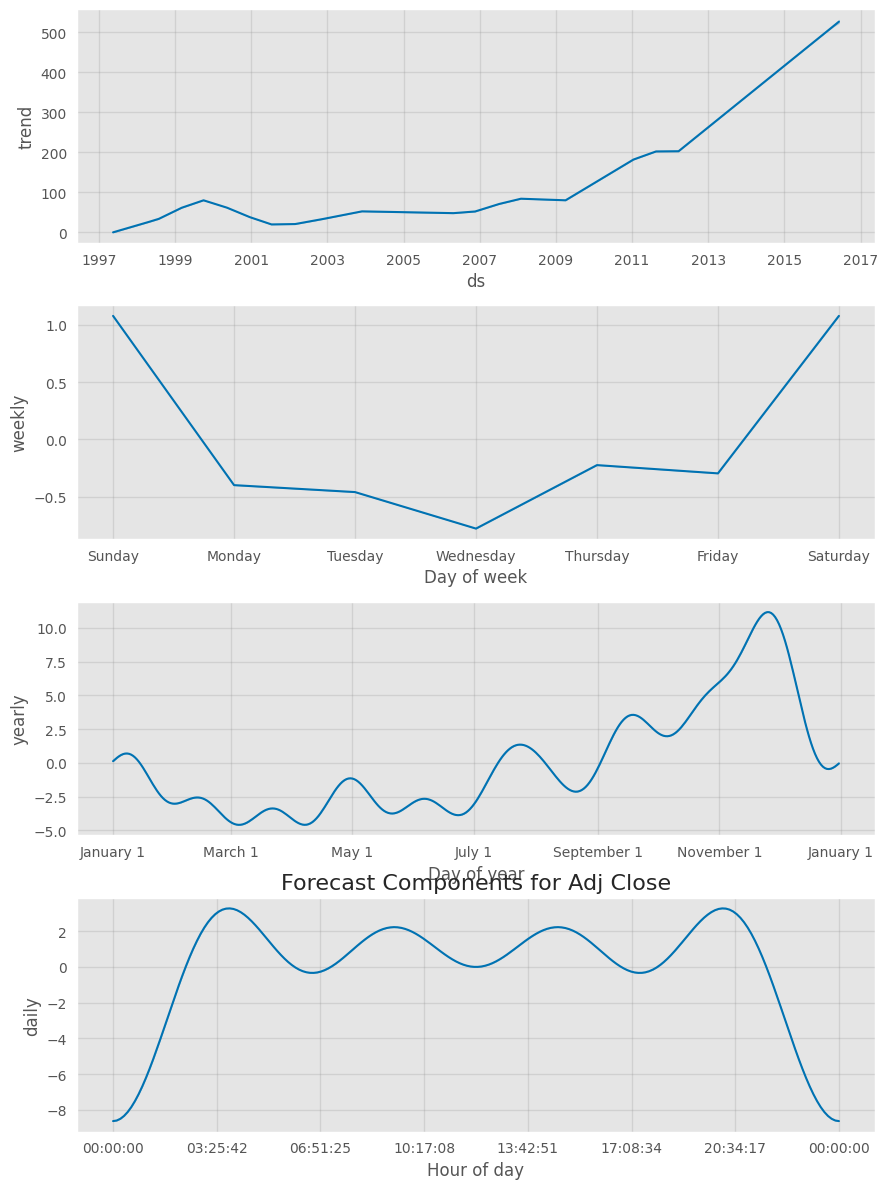

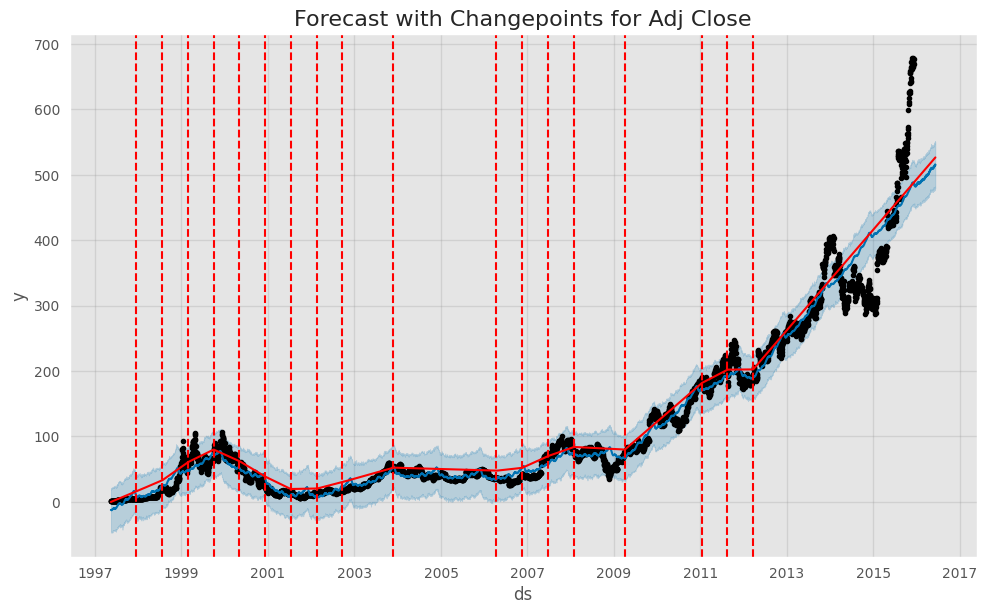

15:26:06 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing


Feature: Volume
             ds          yhat    yhat_lower    yhat_upper
4850 2016-06-03  1.622411e+06 -5.987639e+06  9.640038e+06
4851 2016-06-04  1.174826e+07  3.452281e+06  1.974226e+07
4852 2016-06-05  1.181924e+07  3.689551e+06  1.933239e+07
4853 2016-06-06  1.548229e+06 -7.084906e+06  9.717515e+06
4854 2016-06-07  2.318548e+06 -6.383228e+06  1.021684e+07


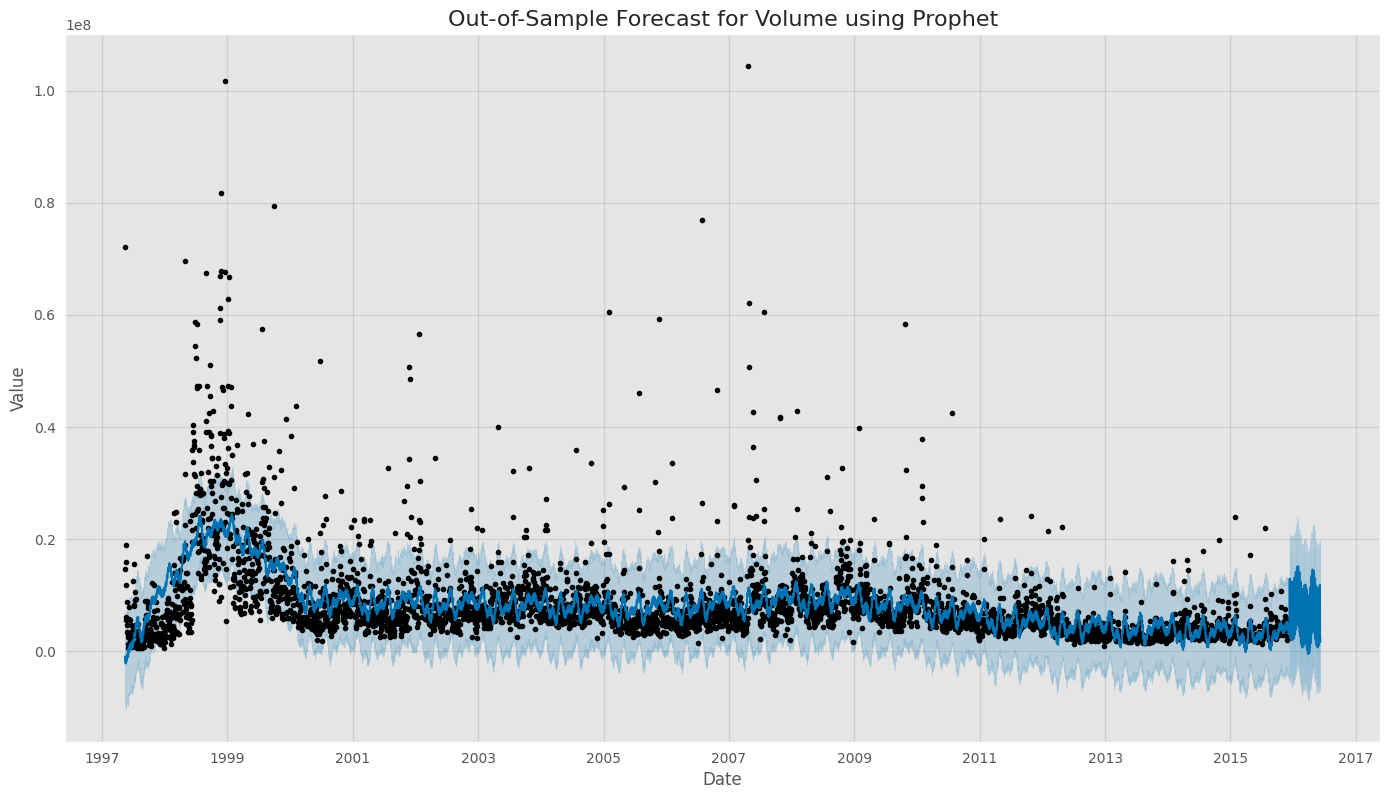

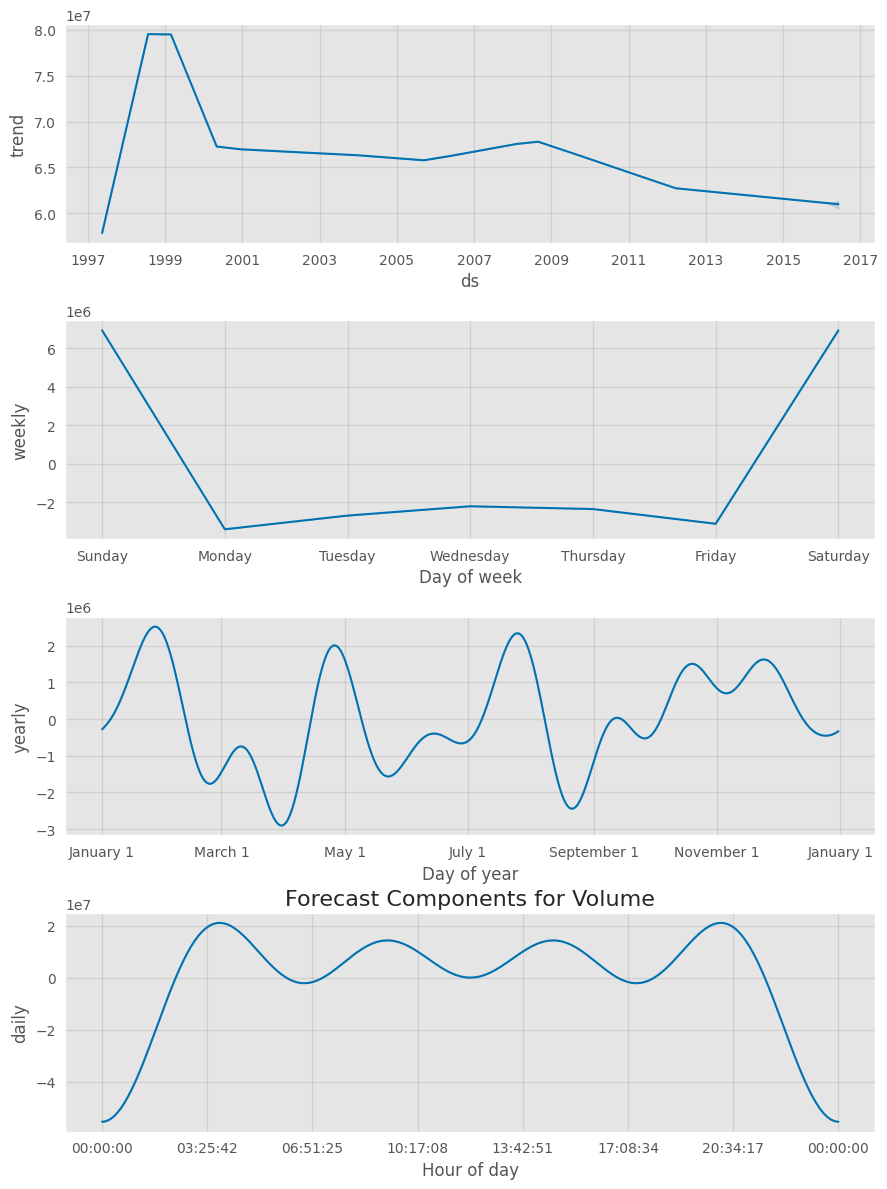

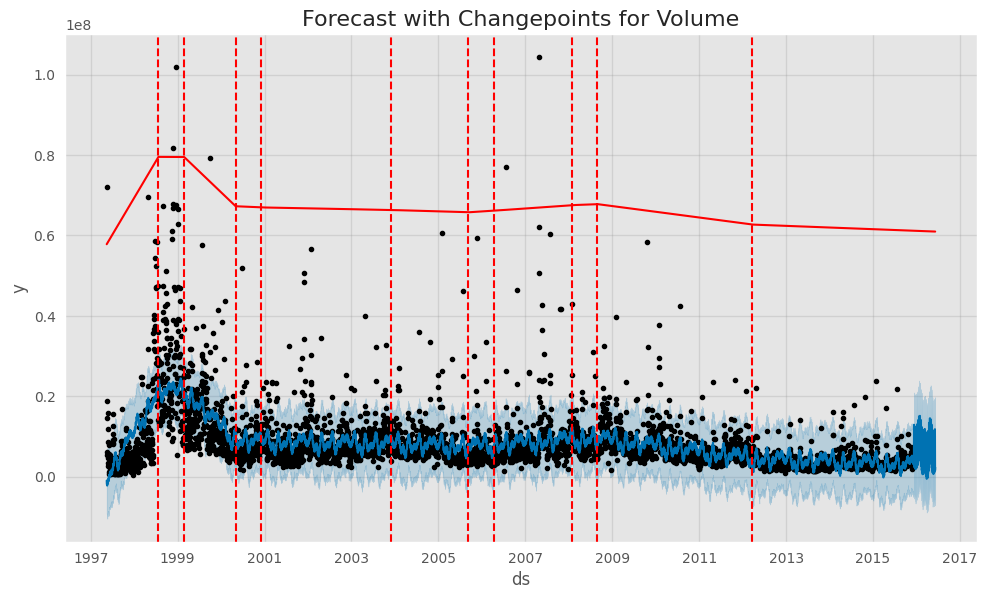

In [52]:
metrics = {}
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_true_safe = np.where(y_true == 0, epsilon, y_true)
    
    mape = np.mean(np.abs((y_true_safe - y_pred) / y_true_safe)) * 100
    return mape

for feature in features:
    df_feature = df[['Date', feature]].rename(columns={'Date': 'ds', feature: 'y'})
    df_feature['ds'] = pd.to_datetime(df_feature['ds'])
    
    train_size = int(len(df_feature) * 0.8)
    df_train = df_feature.iloc[:train_size]
    df_test = df_feature.iloc[train_size:]
    
    model_prophet = Prophet(daily_seasonality=True)
    model_prophet.fit(df_train)
    
    future = df_test[['ds']]
    forecast = model_prophet.predict(future)
    
    y_true = df_test['y']
    y_pred = forecast['yhat']
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics[feature] = {'MAE': mae, 'MAPE': mape, 'R^2': r2}
    
    future_full = model_prophet.make_future_dataframe(periods=182)
    forecast_full = model_prophet.predict(future_full)
    
    print(f"Feature: {feature}")
    print(forecast_full[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
    
    fig1 = model_prophet.plot(forecast_full, figsize=(14, 8))
    plt.title(f"Out-of-Sample Forecast for {feature} using Prophet", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.show()
    
    fig2 = model_prophet.plot_components(forecast_full)
    plt.title(f"Forecast Components for {feature}", fontsize=16)
    plt.show()
    
    fig3 = model_prophet.plot(forecast_full)
    plt.title(f"Forecast with Changepoints for {feature}", fontsize=16)
    a = add_changepoints_to_plot(fig3.gca(), model_prophet, forecast_full)
    plt.show()



### Metrics

In [53]:
prophet_metrics_df = pd.DataFrame(metrics).T.reset_index()
prophet_metrics_df.columns = ['Feature', 'MAE',  'MAPE', 'R^2']

In [54]:
close_metrics = prophet_metrics_df[prophet_metrics_df['Feature'] == 'Close'].iloc[0]

mae_prophet = close_metrics['MAE']
mape_prophet = close_metrics['MAPE']
r2_prophet = close_metrics['R^2']

new_model = 'Prophet'
new_mae = mae_prophet
new_mape = mape_prophet
new_r2 = r2_prophet

new_data = pd.DataFrame({
    'Model': [new_model],
    'MAE': [new_mae],
    'MAPE': [new_mape],
    'R^2': [new_r2]
})

metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)


## LSTM

In [55]:
df = pd.read_csv(file_path)

In [56]:
df['Date'] = pd.to_datetime(df['Date'])

In [57]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Adj Close        Close  Daily Return       Date         High  \
0        1.958333     1.958333      0.001944 1997-05-15     2.500000   
1        1.729167     1.729167     -0.117021 1997-05-16     1.979167   
2        1.708333     1.708333     -0.012048 1997-05-19     1.770833   
3        1.635417     1.635417     -0.042683 1997-05-20     1.750000   
4        1.427083     1.427083     -0.127388 1997-05-21     1.645833   
...           ...          ...           ...        ...          ...   
5837  3055.209961  3055.209961      0.015388 2020-07-27  3098.000000   
5838  3000.330078  3000.330078     -0.017963 2020-07-28  3077.090088   
5839  3033.530029  3033.530029      0.011065 2020-07-29  3039.159912   
5840  3051.879883  3051.879883      0.006049 2020-07-30  3092.000000   
5841  3164.679932  3164.679932      0.036961 2020-07-31  3246.820068   

              Low  MA for 10 days  MA for 100 days  MA for 50 days  \
0        1.927083      370.959051       355.892522      363.507729   
1        1.708333      370.959051       355.892522      363.507729   
2        1.625000      370.959051       355.892522      363.507729   
3        1.635417      370.959051       355.892522      363.507729   
4        1.375000      370.959051       355.892522      363.507729   
...           ...             ...              ...             ...   
5837  3015.770020     3054.044995      2424.709003     2735.500005   
5838  2995.760010     3045.678003      2435.472003     2747.311006   
5839  2996.770020     3048.143994      2446.796404     2759.456406   
5840  3005.000000     3053.341992      2459.309103     2771.507402   
5841  3151.000000     3073.612988      2472.037703     2784.842202   

             Open    Volume  
0        2.437500  72156000  
1        1.968750  14700000  
2        1.760417   6106800  
3        1.729167   5467200  
4        1.635417  18853200  
...           ...       ...  
5837  3062.000000   4170500  
5838  3054.270020   3126700  
5839  3030.989990   2974100  
5840  3014.000000   6128300  
5841  3244.000000   8085500  

[5842 rows x 11 columns]

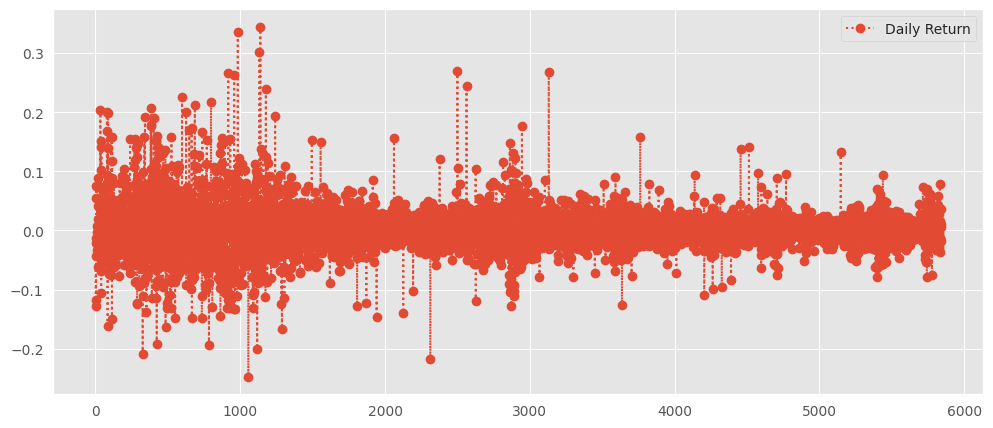

In [58]:
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    df[column_name]=pd.DataFrame.rolling(df['Close'],ma).mean()

df['Daily Return'] = df['Close'].pct_change()
df['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')

df.reset_index(drop=True, inplace=True)
df.fillna(df.mean(), inplace=True)

df.sort_index(axis=1,ascending=True)



In [59]:
fig = make_subplots(rows=5, cols=2, subplot_titles=('Close', 'Volume', 'Open', 'High', 'Low', 'Adj Close',"Daily Return","MA for 10 days","MA for 100 days"	,"MA for 50 days"))
fig.update_layout(title_text='Distribution of Features', title_x=0.5, template='plotly_white', font=dict(size=10))
fig.update_layout(font=dict(size=10))
fig.add_trace(go.Histogram(x=df['Close'], name='Close'), row=1, col=1)
fig.add_trace(go.Histogram(x=df['Volume'], name='Volume'), row=1, col=2)
fig.add_trace(go.Histogram(x=df['Open'], name='Open'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['High'], name='High'), row=2, col=2)
fig.add_trace(go.Histogram(x=df['Low'], name='Low'), row=3, col=1)
fig.add_trace(go.Histogram(x=df['Adj Close'], name='Adj Close'), row=3, col=2)
fig.add_trace(go.Histogram(x=df['Daily Return'], name='Daily Return'), row=4, col=1)
fig.add_trace(go.Histogram(x=df['MA for 10 days'], name='MA for 10 days'), row=4, col=2)
fig.add_trace(go.Histogram(x=df['MA for 100 days'], name='MA for 100 days'), row=5, col=1)
fig.add_trace(go.Histogram(x=df['MA for 50 days'], name='MA for 50 days'), row=5, col=2)

fig.update_layout(title_text='Distribution of Features', title_x=0.5, template='plotly_white')

fig.show()

In [60]:
correlation = df.corr()
fig = px.imshow(correlation, text_auto=True, title='Correlation Matrix')
fig.update_layout(title_text='Correlation Matrix', title_x=0.5, template='plotly_dark')
fig.show()

In [61]:
features = ['Open', 'High', 'Low', 'Volume', "Daily Return","MA for 10 days","MA for 100 days"	,"MA for 50 days"]
target = 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features + [target]])
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1]) 
        y.append(data[i, -1]) 
    return np.array(X), np.array(y)
sequence_length = 60 
X, y = create_sequences(scaled_data, sequence_length)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [62]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1)) 
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 4.8630e-04 - val_loss: 0.0013
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 6.3631e-05 - val_loss: 0.0011
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 4.9407e-05 - val_loss: 9.3679e-04
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 4.0748e-05 - val_loss: 0.0027
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 3.7741e-05 - val_loss: 7.1017e-04
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 2.8262e-05 - val_loss: 0.0011
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 3.2996e-05 - val_loss: 0.0010
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 3.3175e-05 - val_loss: 6.4355e-04
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 2.2361e-05 - val_loss: 4.7399e-04
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 3.2590e-05 - val_loss: 0.0011
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 2.4076e-

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


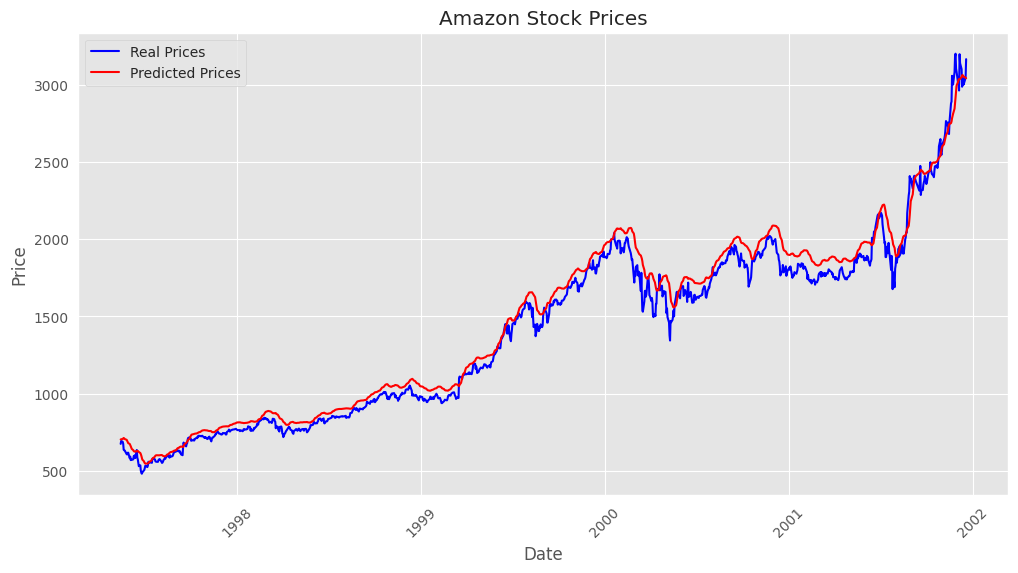

In [63]:
predicted_prices_scaled = model_lstm.predict(X_test)

real_prices_scaled = y_test.reshape(-1, 1)

predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices_scaled), len(features))), predicted_prices_scaled), axis=1))[:, -1]
real_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(real_prices_scaled), len(features))), real_prices_scaled), axis=1))[:, -1]


dates_test = df['Date'] 
dates_test = pd.to_datetime(dates_test) 
dates_test = dates_test[:len(real_prices)]


plt.figure(figsize=(12, 6))
plt.plot(dates_test, real_prices, color='blue', label='Real Prices')
plt.plot(dates_test, predicted_prices, color='red', label='Predicted Prices')
plt.title('Amazon Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Metrics

In [64]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae_lstm = mean_absolute_error(real_prices, predicted_prices)

r2_lstm = r2_score(real_prices, predicted_prices)

mape_lstm = mean_absolute_percentage_error(real_prices, predicted_prices)

print(f'MAPE: {mape_lstm:.2f}%')
print(f'MAE: {mae_lstm:.2f}')
print(f'R2 Score: {r2_lstm:.4f}')


MAPE: 5.25%
MAE: 69.62
R2 Score: 0.9775


In [65]:
new_model = 'LSTM'
new_mae = mae_lstm
new_mape = mape_lstm
new_r2 = r2_lstm

new_data = pd.DataFrame({
    'Model': [new_model],
    'MAE': [new_mae],
    'MAPE': [new_mape],
    'R^2': [new_r2]
})

metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)


## LSTM-CNN-Raw Data

In [66]:
df = pd.read_csv(file_path)

In [67]:
df.head()

Date      Open      High       Low     Close  Adj Close    Volume
0  1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1  1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
2  1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
3  1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
4  1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200

In [68]:
df['Date'] = pd.to_datetime(df['Date'])

In [69]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [70]:
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features + [target]])

scaler_folder = '..\\scaler'
if not os.path.exists(scaler_folder):
    os.makedirs(scaler_folder)

joblib.dump(scaler, os.path.join(scaler_folder, 'scaler.save'))


['..\\scaler/scaler.save']

In [71]:

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1]) 
        y.append(data[i, -1]) 
    return np.array(X), np.array(y)

sequence_length = 60 
X, y = create_sequences(scaled_data, sequence_length)
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [72]:
X_train.shape[1], X_train.shape[2]

(60, 4)

In [73]:
model_lstm_cnn_1 = Sequential()
model_lstm_cnn_1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm_cnn_1.add(MaxPooling1D(pool_size=2))
model_lstm_cnn_1.add(LSTM(units=50, return_sequences=True))
model_lstm_cnn_1.add(Dropout(0.2))
model_lstm_cnn_1.add(LSTM(units=50, return_sequences=False))
model_lstm_cnn_1.add(Dropout(0.2))
model_lstm_cnn_1.add(Dense(units=1)) 
model_lstm_cnn_1.compile(optimizer='adam', loss='mean_squared_error')
model_lstm_cnn_1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 3.7524e-04 - val_loss: 0.0017
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.3150e-05 - val_loss: 0.0011
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.1965e-05 - val_loss: 0.0011
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.5634e-05 - val_loss: 6.5496e-04
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.1356e-05 - val_loss: 6.7937e-04
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.0294e-05 - val_loss: 8.3175e-04
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.8079e-05 - val_loss: 0.0022
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.4783e-05 - val_loss: 6.6571e-04
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.3732e-05 - val_loss: 0.0015
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.5010e-05 - val_loss: 0.0010
Epoch 11/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.8256e-05 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


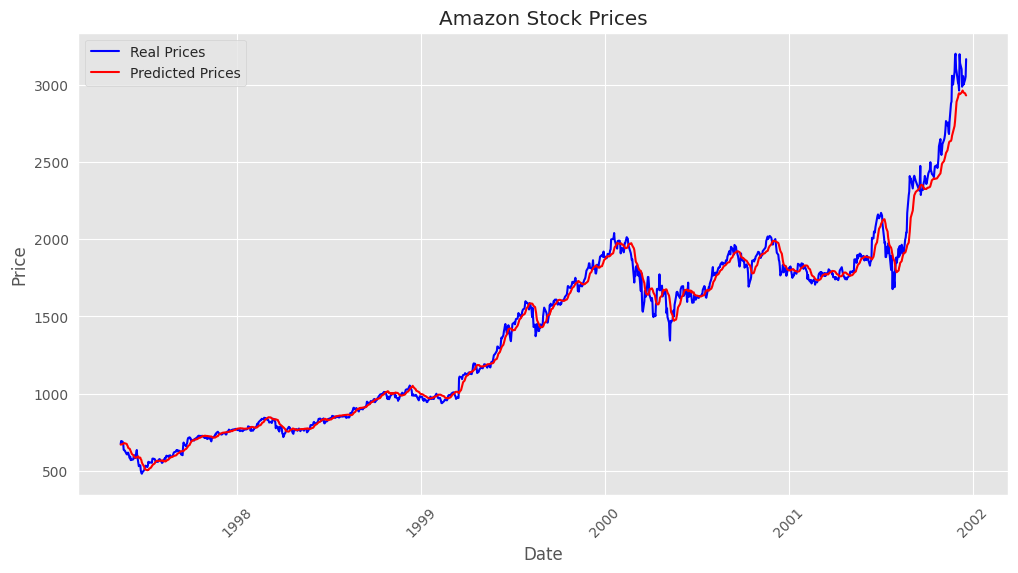

In [74]:
predicted_prices_scaled = model_lstm_cnn_1.predict(X_test)

real_prices_scaled = y_test.reshape(-1, 1)

predicted_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(predicted_prices_scaled), len(features))), predicted_prices_scaled), axis=1))[:, -1]
real_prices = scaler.inverse_transform(np.concatenate((np.zeros((len(real_prices_scaled), len(features))), real_prices_scaled), axis=1))[:, -1]


dates_test = df['Date'] 
dates_test = pd.to_datetime(dates_test) 
dates_test = dates_test[:len(real_prices)]


plt.figure(figsize=(12, 6))
plt.plot(dates_test, real_prices, color='blue', label='Real Prices')
plt.plot(dates_test, predicted_prices, color='red', label='Predicted Prices')
plt.title('Amazon Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Metrics

In [75]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae_lstm_cnn_1 = mean_absolute_error(real_prices, predicted_prices)

r2_lstm_cnn_1 = r2_score(real_prices, predicted_prices)

mape_lstm_cnn_1 = mean_absolute_percentage_error(real_prices, predicted_prices)

print(f'MAPE: {mape_lstm_cnn_1:.2f}%')
print(f'MAE: {mae_lstm_cnn_1:.2f}')
print(f'R2 Score: {r2_lstm_cnn_1:.4f}')


MAPE: 2.75%
MAE: 40.85
R2 Score: 0.9874


In [76]:
new_model = 'LSTM-CNN-Raw Data'
new_mae = mae_lstm_cnn_1
new_mape = mape_lstm_cnn_1
new_r2 = r2_lstm_cnn_1

new_data = pd.DataFrame({
    'Model': [new_model],
    'MAE': [new_mae],
    'MAPE': [new_mape],
    'R^2': [new_r2]
})

metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)


## CNN-LSTM

In [77]:
data = pd.read_csv(file_path)

In [78]:
data.describe()

Open         High          Low        Close    Adj Close  \
count  5842.000000  5842.000000  5842.000000  5842.000000  5842.000000   
mean    372.707174   376.921392   368.114569   372.746660   372.746660   
std     585.571802   591.766458   578.660700   585.607655   585.607655   
min       1.406250     1.447917     1.312500     1.395833     1.395833   
25%      37.955001    38.547501    37.207500    37.927499    37.927499   
50%      83.428749    84.945000    81.656250    83.459999    83.459999   
75%     359.729988   363.439987   356.280006   360.047501   360.047501   
max    3251.060059  3344.290039  3151.000000  3200.000000  3200.000000   

             Volume  
count  5.842000e+03  
mean   7.519048e+06  
std    7.282683e+06  
min    4.872000e+05  
25%    3.684900e+06  
50%    5.657200e+06  
75%    8.533400e+06  
max    1.043292e+08

In [79]:
data.Date = pd.to_datetime(data.Date)
data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)
data.head()

Date      Open      High       Low     Close  Adj Close    Volume
0 1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1 1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
2 1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
3 1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
4 1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200

Adj Close        Close  Daily Return       Date         High  \
0        1.958333     1.958333      0.001944 1997-05-15     2.500000   
1        1.729167     1.729167     -0.117021 1997-05-16     1.979167   
2        1.708333     1.708333     -0.012048 1997-05-19     1.770833   
3        1.635417     1.635417     -0.042683 1997-05-20     1.750000   
4        1.427083     1.427083     -0.127388 1997-05-21     1.645833   
...           ...          ...           ...        ...          ...   
5837  3055.209961  3055.209961      0.015388 2020-07-27  3098.000000   
5838  3000.330078  3000.330078     -0.017963 2020-07-28  3077.090088   
5839  3033.530029  3033.530029      0.011065 2020-07-29  3039.159912   
5840  3051.879883  3051.879883      0.006049 2020-07-30  3092.000000   
5841  3164.679932  3164.679932      0.036961 2020-07-31  3246.820068   

              Low  MA for 10 days  MA for 100 days  MA for 50 days  \
0        1.927083      370.959051       355.892522      363.507729   
1        1.708333      370.959051       355.892522      363.507729   
2        1.625000      370.959051       355.892522      363.507729   
3        1.635417      370.959051       355.892522      363.507729   
4        1.375000      370.959051       355.892522      363.507729   
...           ...             ...              ...             ...   
5837  3015.770020     3054.044995      2424.709003     2735.500005   
5838  2995.760010     3045.678003      2435.472003     2747.311006   
5839  2996.770020     3048.143994      2446.796404     2759.456406   
5840  3005.000000     3053.341992      2459.309103     2771.507402   
5841  3151.000000     3073.612988      2472.037703     2784.842202   

             Open    Volume  
0        2.437500  72156000  
1        1.968750  14700000  
2        1.760417   6106800  
3        1.729167   5467200  
4        1.635417  18853200  
...           ...       ...  
5837  3062.000000   4170500  
5838  3054.270020   3126700  
5839  3030.989990   2974100  
5840  3014.000000   6128300  
5841  3244.000000   8085500  

[5842 rows x 11 columns]

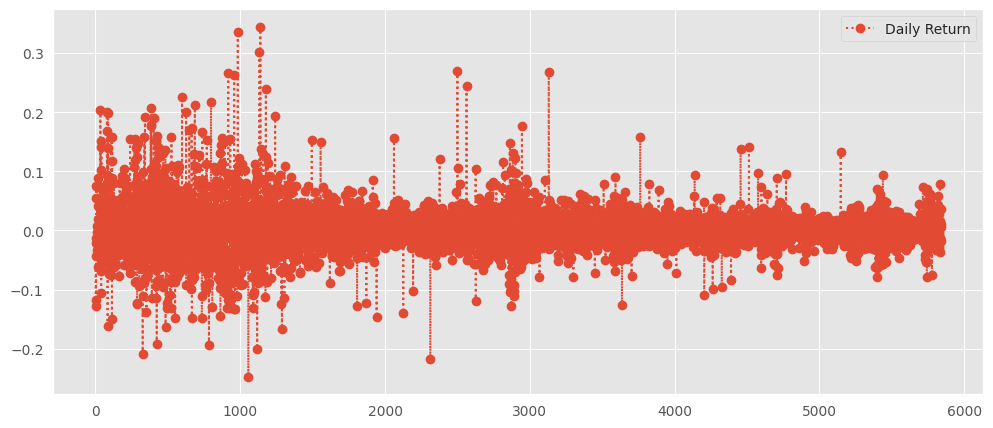

In [80]:
ma_day = [10,50,100]

for ma in ma_day:
    column_name = "MA for %s days" %(str(ma))
    data[column_name]=pd.DataFrame.rolling(data['Close'],ma).mean()

data['Daily Return'] = data['Close'].pct_change()
data['Daily Return'].plot(figsize=(12,5),legend=True,linestyle=':',marker='o')

data.reset_index(drop=True, inplace=True)
data.fillna(data.mean(), inplace=True)

data.sort_index(axis=1,ascending=True)



In [81]:
data.head()

Date      Open      High       Low     Close  Adj Close    Volume  \
0 1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000   
1 1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000   
2 1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800   
3 1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200   
4 1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200   

   MA for 10 days  MA for 50 days  MA for 100 days  Daily Return  
0      370.959051      363.507729       355.892522      0.001944  
1      370.959051      363.507729       355.892522     -0.117021  
2      370.959051      363.507729       355.892522     -0.012048  
3      370.959051      363.507729       355.892522     -0.042683  
4      370.959051      363.507729       355.892522     -0.127388

In [82]:
data.shape

(5842, 11)

In [83]:
X = []
Y = []
window_size=100
for i in range(1 , len(data) - window_size -1 , 1):
    first = data.iloc[i,2]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((data.iloc[i + j, 2] - first) / first)
    temp2.append((data.iloc[i + window_size, 2] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   8.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total ti

In [84]:
model_cnn_lstm_2 = tf.keras.Sequential()

model_cnn_lstm_2.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling1D(2)))
model_cnn_lstm_2.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling1D(2)))
model_cnn_lstm_2.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model_cnn_lstm_2.add(TimeDistributed(MaxPooling1D(2)))
model_cnn_lstm_2.add(TimeDistributed(Flatten()))

model_cnn_lstm_2.add(Bidirectional(LSTM(100, return_sequences=True)))
model_cnn_lstm_2.add(Dropout(0.5))
model_cnn_lstm_2.add(Bidirectional(LSTM(100, return_sequences=False)))
model_cnn_lstm_2.add(Dropout(0.5))

model_cnn_lstm_2.add(Dense(1, activation='linear'))
model_cnn_lstm_2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = model_cnn_lstm_2.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=20,batch_size=40, verbose=1, shuffle =True)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - loss: 0.1334 - mae: 0.2110 - mse: 0.1334 - val_loss: 0.0341 - val_mae: 0.1086 - val_mse: 0.0341
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0401 - mae: 0.1182 - mse: 0.0401 - val_loss: 0.0243 - val_mae: 0.0914 - val_mse: 0.0243
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0356 - mae: 0.1064 - mse: 0.0356 - val_loss: 0.0237 - val_mae: 0.0882 - val_mse: 0.0237
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0309 - mae: 0.1009 - mse: 0.0309 - val_loss: 0.0261 - val_mae: 0.0936 - val_mse: 0.0261
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0327 - mae: 0.1033 - mse: 0.0327 - val_loss: 0.0194 - val_mae: 0.0871 - val_mse: 0.0194
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0279 - mae: 0.0990 - mse: 0.0279 - val_loss: 0.0207 - val_mae: 0.0971 - val_mse: 0.0207
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0293 - mae: 0.0998 - mse: 0.02

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 98, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 49, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 1, 47, 128)     │        24,704 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1, 23, 128)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 21, 64)      │        24,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 1, 10, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 1, 640)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 200)         │       592,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,650,205 (10.11 MB)

 Trainable params: 883,401 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,766,804 (6.74 MB)

None


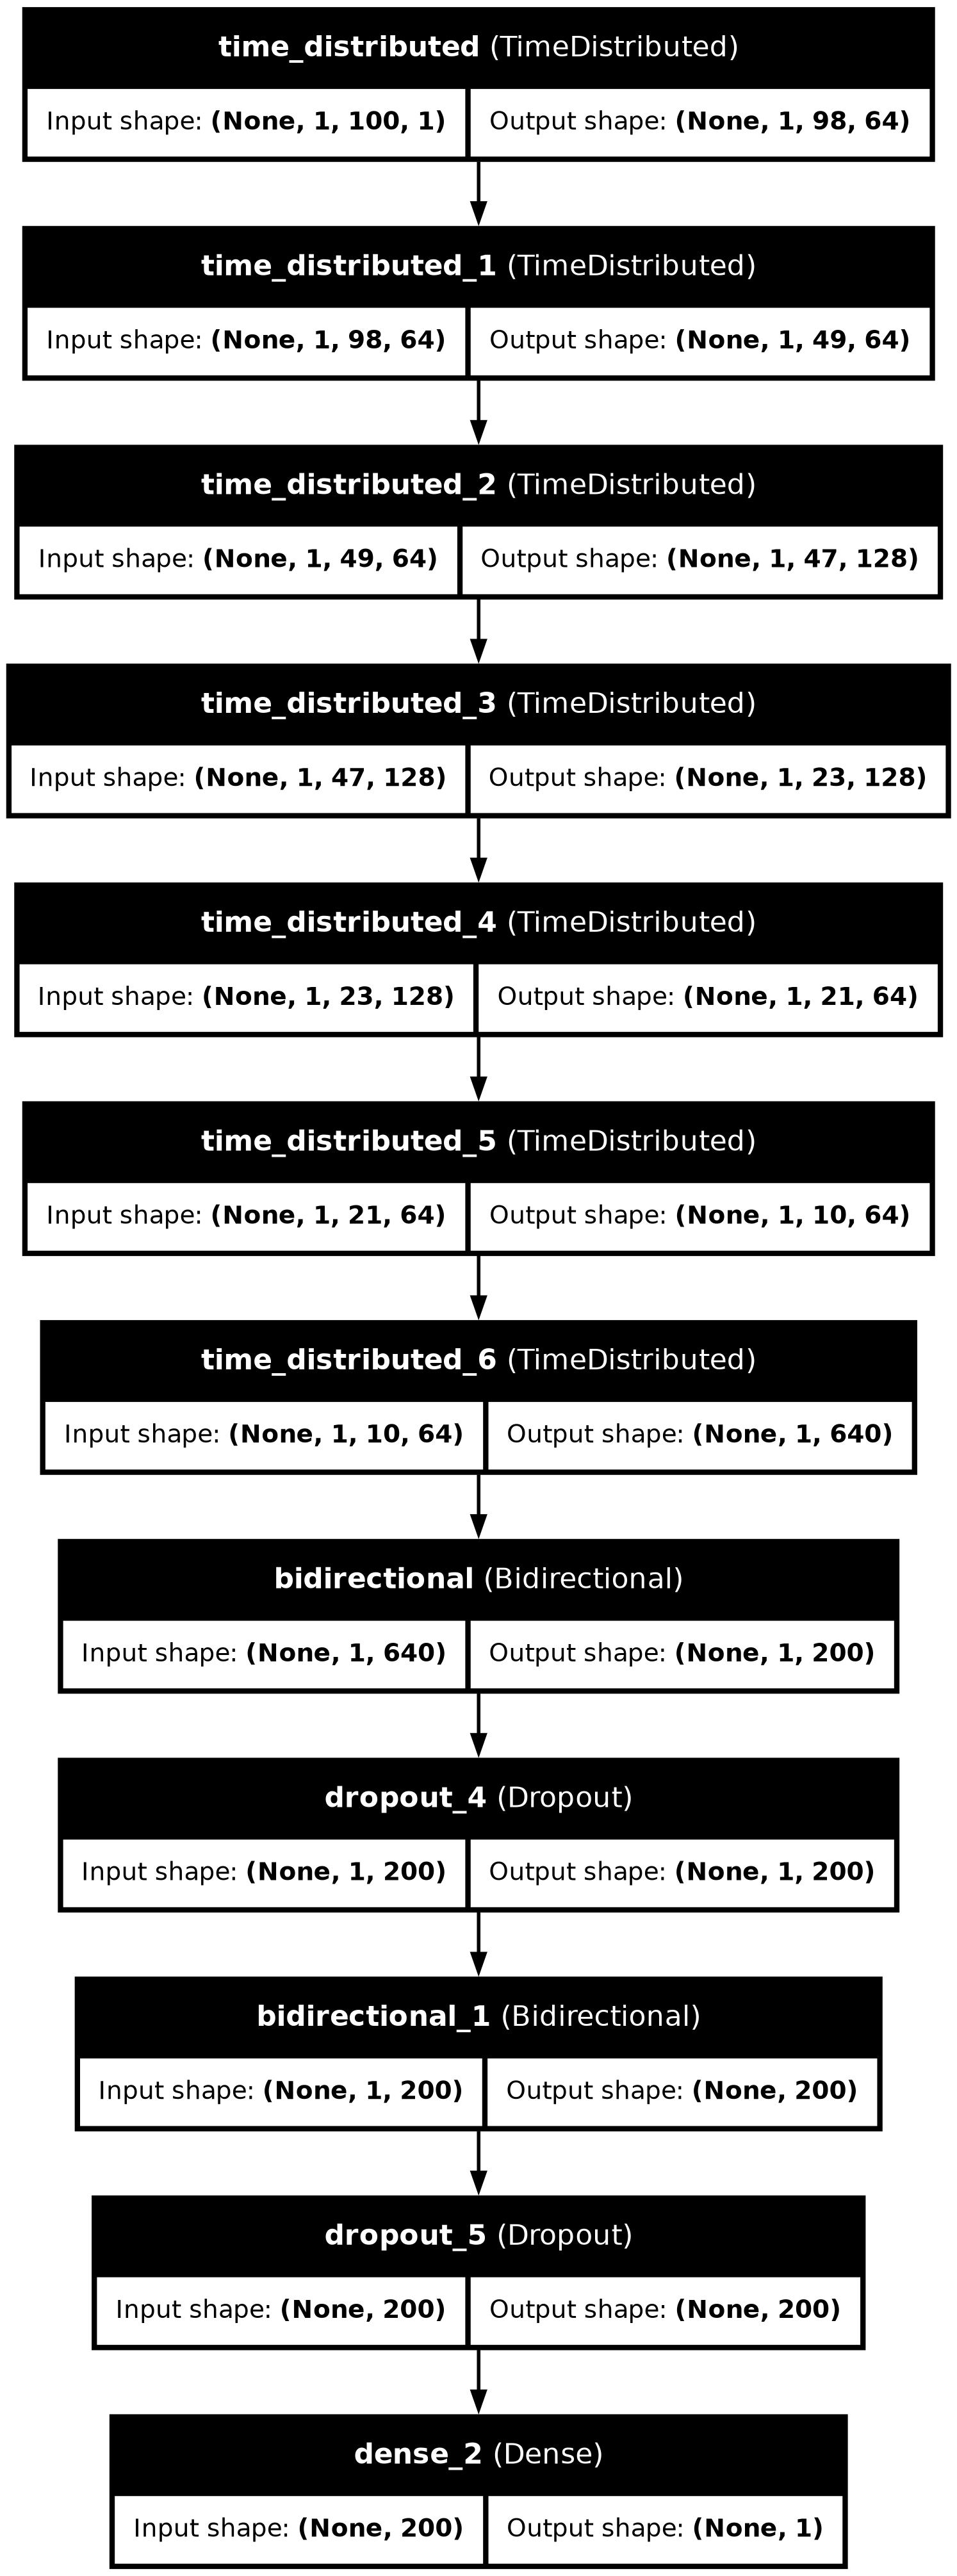

In [85]:
print(model_cnn_lstm_2.summary())
plot_model(model_cnn_lstm_2, to_file='model_cnn_lstm.png', show_shapes=True, show_layer_names=True)

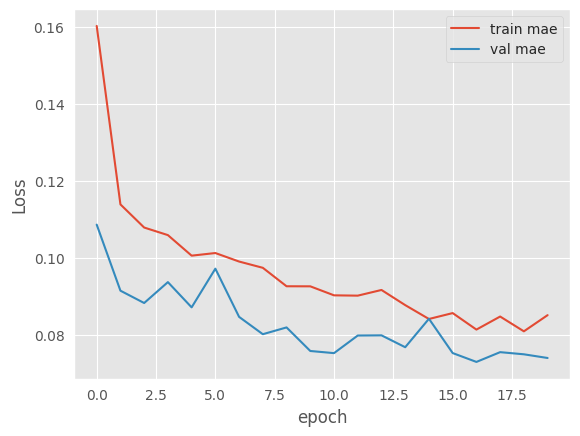

In [86]:
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

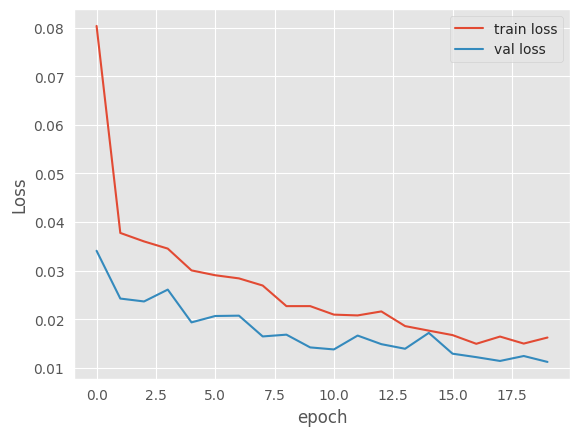

In [87]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

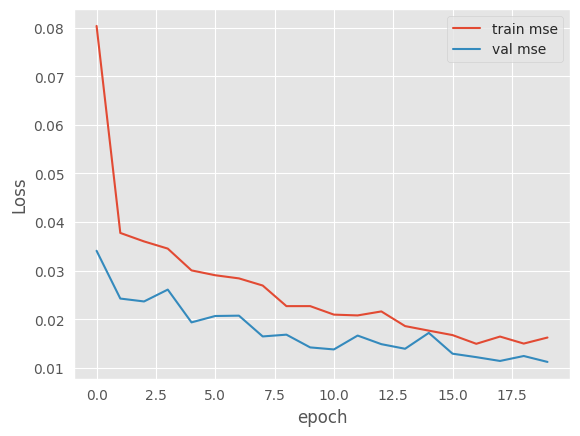

In [88]:
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

In [89]:
model_cnn_lstm_2.evaluate(test_X, test_Y)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 - mae: 0.0743 - mse: 0.0118


[0.01121924165636301, 0.01121924165636301, 0.07390359789133072]

### Metrics

In [90]:
yhat_probs = model_cnn_lstm_2.predict(test_X, verbose=0)
yhat_probs = yhat_probs[:, 0]

test_Y_reshaped = test_Y.reshape(-1, 1)

var_cnn_lstm_2 = explained_variance_score(test_Y_reshaped, yhat_probs)
print('Variance: %f' % var_cnn_lstm_2)

r2_cnn_lstm_2 = r2_score(test_Y_reshaped, yhat_probs)
print('R2 Score: %f' % r2_cnn_lstm_2)

max_err_cnn_lstm_2 = max_error(test_Y_reshaped, yhat_probs)
print('Max Error: %f' % max_err_cnn_lstm_2)

mae_cnn_lstm_2 = mean_absolute_error(test_Y_reshaped, yhat_probs)
print(f'MAE: {mae_cnn_lstm_2:.4f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1), np.array(y_pred).reshape(-1)
    non_zero_indices = y_true != 0
    y_true = y_true[non_zero_indices]
    y_pred = y_pred[non_zero_indices]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_cnn_lstm_2 = mean_absolute_percentage_error(test_Y_reshaped, yhat_probs)
print(f'MAPE: {mape_cnn_lstm_2:.4f}')


Variance: 0.951595
R2 Score: 0.949569
Max Error: 0.641604
MAE: 0.0739
MAPE: 107.2511


In [91]:
new_model = 'CNN-LSTM-Processing Data'
new_mae = mae_cnn_lstm_2
new_mape = mape_cnn_lstm_2
new_r2 = r2_cnn_lstm_2

new_data = pd.DataFrame({
    'Model': [new_model],
    'MAE': [new_mae],
    'MAPE': [new_mape],
    'R^2': [new_r2]
})

metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


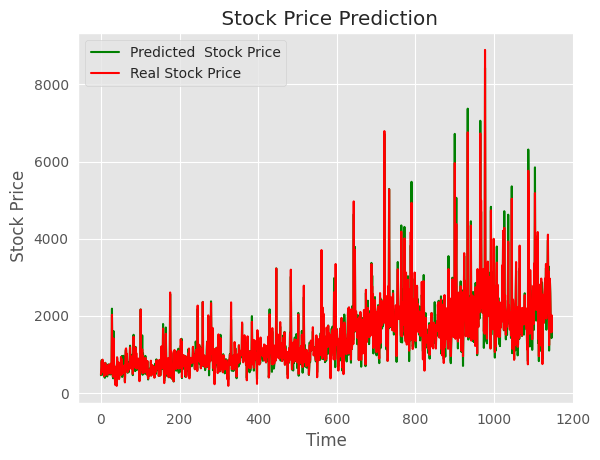

In [92]:
predicted  = model_cnn_lstm_2.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

# Results

In [93]:
metrics_df

Model         MAE        MAPE       R^2
0                    SARIMA  363.228964   17.413083 -0.971854
1   Random Forest Regressor    0.546649    0.154870  0.999984
2                   Prophet  738.359969   46.667898 -1.308351
3                      LSTM   69.620854    5.249728  0.977478
4         LSTM-CNN-Raw Data   40.851916    2.751465  0.987422
5  CNN-LSTM-Processing Data    0.073904  107.251138  0.949569

In [94]:
model_folder = '..\\model'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
model_lstm_cnn_1.save('..\\model\\model.keras')